In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import datetime
import math

In [2]:
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import pmdarima as pm

In [2]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

Importing plotly failed. Interactive plots will not work.


## Obsah
- [Data z Klementina](#Data-z-Klementina)
- [Smoothing](#Smoothing)
  - [Konstanta](#Konstanta)
  - [Exponential smoothing](#Exponential-smoothing)
  - [Double exponential smoothing](#Double-exponential-smoothing)
  - [Triple exponential smoothoing (alias Holt-Winters)](#Triple-exponential-smoothoing-\(alias-Holt-Winters\))
- [ARIMA a příbuzné algoritmy](#ARIMA-a-příbuzné-algoritmy)
  - [ACF a PACF](#ACF-a-PACF)
  - [ARIMA](#ARIMA)
  - [SARIMA](#SARIMA)
  - [(S)ARIMAX](#\(S\)ARIMAX)
- [Facebook Prophet](#Facebook-Prophet)
  - [Trend a saturace růstu](#Trend-a-saturace-růstu)
  - [Changepointy v trendu](#Changepointy-v-trendu)
  - [Sezónnost](#Sezónnost)
  - [Svátky](#Svátky)

## Data z Klementina
V tomto textu budeme různé způsoby predikce časových řad demonstrovat na teplotách naměřených v Klementinu. Data jsou k dispozici [zde](https://www.chmi.cz/historicka-data/pocasi/praha-klementinum#).  

Nejprve data načteme a ze sloupců pro den, měsíc a rok vyrobíme jeden sloupec obsahující celé datum.

In [3]:
klementinum_frame_raw = pd.read_excel("PKLM_pro_portal.xlsx", engine="openpyxl", sheet_name="data")
klementinum_frame_raw[["day", "month", "year", "temperature"]] = klementinum_frame_raw[["den", "měsíc", "rok", "T-AVG"]]
klementinum_frame_raw["date"] = pd.to_datetime(klementinum_frame_raw[["day", "month", "year"]])
klementinum_frame = klementinum_frame_raw[["date", "day", "month", "year", "temperature"]].copy()

In [4]:
klementinum_frame.head()

,date,day,month,year,temperature
0,1775-01-01,1,1,1775,-7.0
1,1775-01-02,2,1,1775,-2.2
2,1775-01-03,3,1,1775,-1.0
3,1775-01-04,4,1,1775,0.1
4,1775-01-05,5,1,1775,2.2


Pro velice letmé seznámení se s daty si necháme vykreslit jednak závislost na čase během několika málo let, jednak závislost průměrné celoroční teploty na roku.

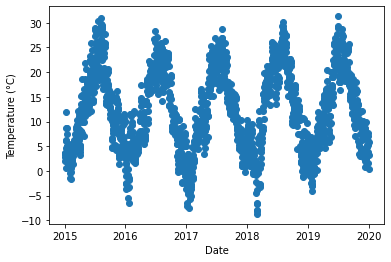

In [5]:
klementinum_subframe = klementinum_frame[
    (klementinum_frame["date"]>= datetime.datetime.strptime("2015-01-01", "%Y-%m-%d"))
    & (klementinum_frame["date"]< datetime.datetime.strptime("2020-01-01", "%Y-%m-%d"))
]
plt.scatter(klementinum_subframe["date"], klementinum_subframe["temperature"])
plt.xlabel("Date")
plt.ylabel("Temperature (°C)");

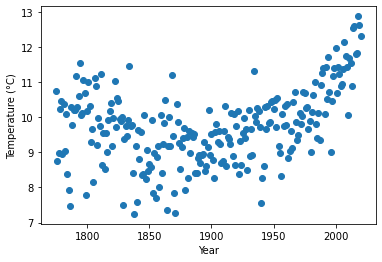

In [6]:
klementinum_avg_by_year = klementinum_frame.groupby("year").agg(avg_temp=("temperature", np.mean))
plt.scatter(klementinum_avg_by_year.index, klementinum_avg_by_year["avg_temp"])
plt.xlabel("Year")
plt.ylabel("Temperature (°C)");

Následně si vyrobíme trénovací a testovací množinu dat.

In [7]:
test_start_day = datetime.datetime.strptime("2018-01-01", "%Y-%m-%d")
test_end_day = datetime.datetime.strptime("2020-12-31", "%Y-%m-%d")

In [8]:
training_frame = klementinum_frame[
    (klementinum_frame["date"]<test_start_day)
]

testing_frame = klementinum_frame[
    (klementinum_frame["date"]>=test_start_day)
    & (klementinum_frame["date"]<=test_end_day)
]

## Smoothing
### Konstanta
Člověk by měl při využívání technik strojového učení výstup oněch technik vždy srovnávat s nějakou baselinou, tj. s nějakým hodně naivním přístupem. Pak se totiž snadno a rychle pozná, pokud ML algoritmus (resp. jeho implementace) spektakulárně selže. V našem případě vezmeme jako baselinu konstantu - jednak hodnotu v posledním dni trénovací množiny (přeci jen je testovacím datům nejblíže), jednak průměrnou hodnotu spočítanou z dat celé trénovací množiny.

In [10]:
const_last_day = training_frame[training_frame["date"]==max(training_frame["date"])]["temperature"].values[0]
const_avg = np.mean(training_frame["temperature"])
print(f"Constant (last day): {const_last_day}")
print(f"Constant (average): {const_avg}")

Constant (last day): 10.3
Constant (average): 9.712700272663767


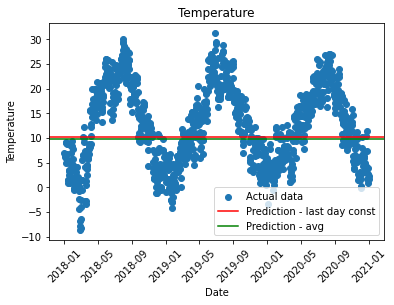

In [11]:
plt.scatter(testing_frame["date"], testing_frame["temperature"])
plt.axhline(y=const_last_day, color="r", linestyle="-")
plt.axhline(y=const_avg, color="g", linestyle="-")
plt.title("Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend(["Actual data", "Prediction - last day const", "Prediction - avg"])
plt.xticks(rotation=45);

Z obrázků vidíme, že výsledky obou predikcí byly hodně podobné - a hodně mimo. Kdyby ale v teplotách nebyla jasná závislost na ročním období, jak bychom poznali, která z predikcí je lepší? Možná by to šlo rozlišit okometricky, nicméně vhodnější  bude spočítání RMSE (root mean square error).

In [12]:
def get_rmse_for_const(numbers_serie, constant):
    return math.sqrt(
        sum(
            (numbers_serie-constant)*(numbers_serie-constant)
        )/len(testing_frame)
    )

rmse_last_day = get_rmse_for_const(testing_frame["temperature"], const_last_day)
rmse_avg = get_rmse_for_const(testing_frame["temperature"], const_avg)
print(f"RMSE (last day): {round(rmse_last_day):,}")
print(f"RMSE (avg): {round(rmse_avg):,}")

RMSE (last day): 8
RMSE (avg): 8


Na takovýchto datech je to asi jedno, nicméně... nebylo by lepší spíše než výše uvedené extrémy brát v uváhu posledních **n** hodnot? Takto vytvořené časové okno se označuje jako "sliding window" a vypočtený průměr jako "moving average". Samozřejmě problematickým bodem je určení velikost okna...

Constant (moving average): 5.140000000000001
RMSE (moving average): 11


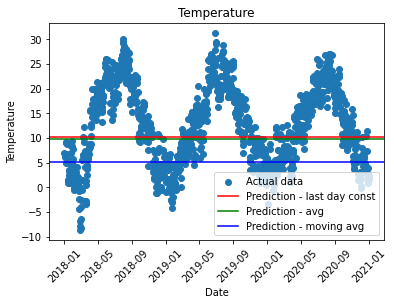

In [13]:
sliding_window = 10
const_mov_avg = np.mean(training_frame.tail(sliding_window)["temperature"])
rmse_mov_avg = get_rmse_for_const(testing_frame["temperature"], const_mov_avg)
print(f"Constant (moving average): {const_mov_avg}")
print(f"RMSE (moving average): {round(rmse_mov_avg):,}")

plt.scatter(testing_frame["date"], testing_frame["temperature"])
plt.axhline(y=const_last_day, color="r", linestyle="-")
plt.axhline(y=const_avg, color="g", linestyle="-")
plt.axhline(y=const_mov_avg, color="b", linestyle="-")
plt.title("Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend(["Actual data", "Prediction - last day const", "Prediction - avg", "Prediction - moving avg"])
plt.xticks(rotation=45);

Vidíme, že moving average od předešlých predikcí odskočil. Co se mnohaletého celoročního průměru týče, tak to překvapení není - přeci jen sliding window obsahovalo pouze konec prosince. U predikce z posledního dne fakticky za odskok nemůže způsob výpočtu moving average, ale skutečnost, že 31. prosinec roku 2017 byl v porovnání s předešlými dny překvapivě teplý.  
Drobným vylepšením předchozího přístupu je použití vah - pak mluvíme o "weighted moving average". Samozřejmě krom problému s velikostí okna nám zde pak vyvstává i otázka velikosti vah. Z hlediska algoritmu jsme omezeni jen tím, že celkový součet vah musí být roven 1.

Constant (weighted moving average): 5.145
RMSE (weighted moving average): 11


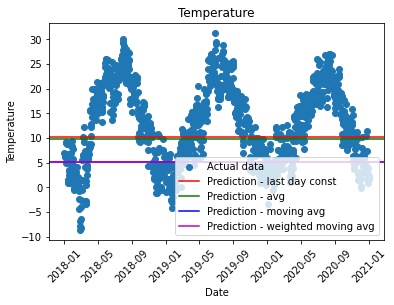

In [14]:
sliding_window = 10
weight_list = [0.05, 0.05, 0.05, 0.05, 0.1, 0.1, 0.1, 0.15, 0.15, 0.2]
const_weigh_mov_avg = np.average(training_frame.tail(sliding_window)["temperature"], weights=weight_list)
rmse_weigh_mov_avg = get_rmse_for_const(testing_frame["temperature"], const_mov_avg)
print(f"Constant (weighted moving average): {const_weigh_mov_avg}")
print(f"RMSE (weighted moving average): {round(rmse_weigh_mov_avg):,}")

legend_list = [
    "Actual data", "Prediction - last day const", 
    "Prediction - avg", "Prediction - moving avg",
    "Prediction - weighted moving avg"
]

plt.scatter(testing_frame["date"], testing_frame["temperature"])
plt.axhline(y=const_last_day, color="r", linestyle="-")
plt.axhline(y=const_avg, color="g", linestyle="-")
plt.axhline(y=const_mov_avg, color="b", linestyle="-")
plt.axhline(y=const_weigh_mov_avg, color="m", linestyle="-")
plt.title("Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend(legend_list)
plt.xticks(rotation=45);

### Exponential smoothing
Poznamenejme úvodem, že při psaní kapitol týkajících se všelijakých forem smoothingu bylo extenzivně čerpáno [odtud](https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/).  

Když se podíváme na metody popsané výše, může nás napadnout zkusit je všechny sloučit do jedné. Výsledkem by byl vážený průměr beroucí v úvahu celou časovou řadu, avšak používající váhy, které s rostoucí vzdáleností od koncového bodu (dejme tomu současnosti) klesají. Jenže jak ony váhy určit?  
V nadpisu této kapitoly vidíme "Exponential smoothing" neboli exponenciální vyhlazení. Jak název napovídá, jedná se o postup, jak vyhladit příliš zubaté grafy, aby se z nich daly vyčíst užitečné informace. Předpis vypadá následovně:

$ \hat{L}_x = \alpha L_x + (1-\alpha)\hat{L}_{x-1}$

Zde se snažíme spočítat "vyhlazenou" (vyhlazení znázorňuje stříška) y-ovou souřadnici bodu - veličiny L - pro hodnotu x. K tomu potřebujeme jednak původní hodnotu y-ové souřadnice tohoto bodu, jednak vyhlazenou souřadnici pro předchozí hodnotu x. Alfa tu zastupuje tzv. smoothing faktor, který říká, jak moc silné (či spíše slabé - vyhlazení je pro $\alpha$ = 1 vypnuté) vyhlazování je.  
To je sice všechno pěkné, ale jak nám to pomůže s predikcí časové řady? Inu, výše uvedený předpis můžeme přepsat na

$ \hat{y}_{t+1} = \alpha y_t + (1-\alpha)\hat{y_{t}}$

Asi pořád ještě nemusí být jasné, proč by zrovna tento předpis měl být k něčemu užitečný. To ale zjistíme, když se pokusíme dobrat významu slova "exponenciální" v názvu algoritmu. Rovnice, kterou jsme napsali, je totiž rekurzivní. Tj. můžeme do ní dále dosazovat:

$ \hat{y}_{t+1} = \alpha y_t + (1-\alpha)\hat{y_{t}} = \alpha y_t + (1-\alpha)(\alpha y_{t-1} + (1-\alpha)\hat{y_{t-1}}) =  \alpha y_t + \alpha (1-\alpha)y_{t-1} + (1-\alpha)^2 (\alpha y_{t-2} + (1-\alpha)\hat{y_{t-2}})$

Vidíme tedy, že výsledná hodnota závisí na všech předchozích hodnotách, ale tyto hodnoty mají na sebe napojeny čím dál tím menší váhy.  
Zkusme ještě dokázat, že suma vah dává jedničku. Přepišme výše uvedený vztah na

$ \hat{y}_{t+1} =  \alpha [y_t + (1-\alpha)y_{t-1} + (1-\alpha)^2 y_{t-2}] + (1-\alpha)^3 \hat{y}_{t-2} $

Druhý člen je kvůli největší mocnině váhy (pro kterou platí $0 < \alpha < 1$) v celém výrazu ze všech částí vzorce nejmenší a tak ho můžeme pominout. Váhy v prvním členu v hranaté závorce tvoří de facto nekonečnou (fakticky má víc než zde ukázané jednotky členů) geometrickou řadu. Pro součet nekonečné qeometrické řady s kvocientem **q** (**|q|**<1) platí

$ 1 + q + q^2 + q^3 + ... = \frac {1}{1-q} $

V našem případě čini kvocient **q** = 1 - $\alpha$. Tj. ve jmenovateli máme samotnou alfu, která se vykrátí s alfou stojící před sumou (aka před hranatou závorkou). Výsledkem je tak jednička alias to, co jsme od sumy vah požadovali. 

Použití exponential smoothingu (spávněji single exponential smoothingu) předpokládá, že v datech není žádný výrazný trend, natož pak sezóní (týdenní, měsíční, roční) výkyvy. Jinak by přeci jen - s vyhlazením nebo bez - nemohla hodnota veličiny v čase **t**+1 záviset z velké části na hodnotě veličiny v čase **t**.  
Metoda poskytuje predikci pouze jednoho bodu od konce trénovacích dat. To by se pravda dalo říci i o předchozích přístupech. Zde však už to jedno číslo přes celou testovací časovou řadu neprotáhneme. Důvod bude jasný, až začneme diskutovat další algoritmy, které ze single exponential smoothingu vycházejí a které se dokáží dívat dále do budoucnosti.

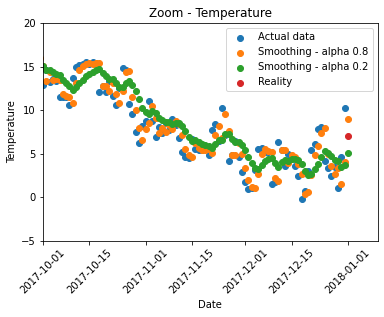

In [12]:
def get_exp_smooth_prediction(time_serie, alpha):
    first_point = time_serie[0]
    smoothed_serie = [first_point]
    
    for elem_index in range(1, len(time_serie)):
        smoothed_point = alpha*time_serie[elem_index] + (1-alpha)*smoothed_serie[elem_index-1]
        smoothed_serie.append(smoothed_point)
    
    return smoothed_serie

date_list_for_smoothed = training_frame["date"] + pd.DateOffset(days=1)
smoothed_a08 = get_exp_smooth_prediction(training_frame["temperature"].to_list(), 0.8)
smoothed_a02 = get_exp_smooth_prediction(training_frame["temperature"].to_list(), 0.2)

x_lim_left = datetime.datetime.strptime("2017-10-01", "%Y-%m-%d").date()
x_lim_right = datetime.datetime.strptime("2018-01-10", "%Y-%m-%d").date()

legend_list = [
    "Actual data", 
    "Smoothing - alpha 0.8", 
    "Smoothing - alpha 0.2",
    "Reality"
]

plt.scatter(training_frame["date"], training_frame["temperature"])
plt.scatter(date_list_for_smoothed,smoothed_a08)
plt.scatter(date_list_for_smoothed,smoothed_a02)
plt.scatter(testing_frame.iloc[0]["date"], testing_frame.iloc[0]["temperature"])
plt.title("Zoom - Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.xlim((x_lim_left, x_lim_right))
plt.ylim((-5, 20))
plt.legend(legend_list)
plt.xticks(rotation=45);

### Double exponential smoothing
Jak již bylo uvedeno, výše diskutovaný single exponential smoothing počítá s tím, že v datech neexistuje žádný trend. Jinými slovy se hodí na "predikci" zašumněné, na čase nezávislé horizontální čáry. Oproti tomu double exponential smoothing už s existencí trendu pracuje.  
Zaveďme si napřed několik termínů. Pod levelem/baselinou/interceptem si představíme právě onu konstantní netrendovou složku časové řady. Budeme ji označovat písmenem **l**. Trend/slope/sklon zase označíme písmenem **b**. Obecně pro trend platí, že  
$b = \frac{\Delta y}{\Delta x}$  

Nicméně v časových řadách, kde se na ose x vyskytují jednotlivé dny, bude jejich vzdálenost jednotková. Tudíž se nám výše uvedený vzoreček redukuje na  

$b = \Delta y = y_{t} - y_{t-1}$   

Pro predikci nyní platí (s předpokladem jednotkového kroku v čase)  

$\hat{y}_{t+1} = l_t + b_t$  

Jak pro baselinu, tak pro trend použijeme exponential smoothing předpis (proto se v názvu algoritmu vyskytuje slovo "double"). Co se baseliny týče, tak u ní si musíme uvědomit, že se jedná o "vyhlazenou" veličinu. Tj. v předpisu pro ni máme v prvním členu nevyhlazenou hodnotu **y** v čase **t**, v druhém členu už vyhlazenou hodnotu v čase **t-1**.  

$l_t = \alpha y_t + (1-\alpha)(l_{t-1} + b_{t-1})$  

U trendu si zase jako nevyhlazenou hodnotu vezmeme rozdíl baselin:  

$b_t = \beta (l_t - l_{t-1}) + (1-\beta)b_{t-1}$  

Vyvstává otázka, jak moc dopředu lze s pomocí double exponential smoothingu koukat dopředu. Lze si [přečíst](https://grisha.org/blog/2016/02/16/triple-exponential-smoothing-forecasting-part-ii/), že spolehlivé jsou dva kroky do budoucnosti. Popravdě mne nenapadá, čím by se takové tvrzení dalo obhájit.

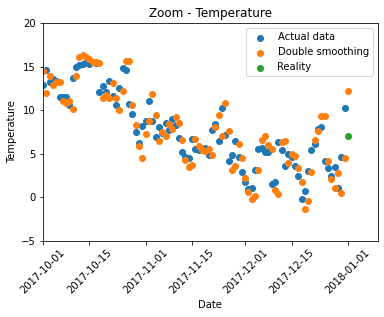

In [13]:
def get_double_exp_smooth_prediction(time_serie, alpha, beta):
    first_point = time_serie[0]
    smoothed_serie = [first_point]
    
    for elem_index in range(1, len(time_serie)):
        #second point of time serie
        if elem_index == 1:
            current_baseline = time_serie[1]
            current_trend = time_serie[1] - time_serie[0]
        #prediction
        if elem_index >= len(time_serie):
            old_timepoint = smoothed_serie[-1]
        else:
            old_timepoint = time_serie[elem_index]

        old_baseline = current_baseline
        old_trend = current_trend

        current_baseline = alpha*old_timepoint + (1-alpha)*(old_baseline + old_trend)
        current_trend = beta*(current_baseline - old_baseline) + (1-beta)*old_trend
        
        smoothed_point = current_baseline + current_trend
        smoothed_serie.append(smoothed_point)
    
    return smoothed_serie


date_list_for_smoothed = training_frame["date"] + pd.DateOffset(days=1)

smoothed_temperature = get_double_exp_smooth_prediction(training_frame["temperature"].to_list(), 0.8, 0.5)

x_lim_left = datetime.datetime.strptime("2017-10-01", "%Y-%m-%d").date()
x_lim_right = datetime.datetime.strptime("2018-01-10", "%Y-%m-%d").date()

legend_list = [
    "Actual data", 
    "Double smoothing", 
    "Reality"
]

plt.scatter(training_frame["date"], training_frame["temperature"])
plt.scatter(date_list_for_smoothed, smoothed_temperature)
plt.scatter(testing_frame.iloc[0]["date"], testing_frame.iloc[0]["temperature"])
plt.title("Zoom - Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.xlim((x_lim_left, x_lim_right))
plt.ylim((-5, 20))
plt.legend(legend_list)
plt.xticks(rotation=45);

### Triple exponential smoothoing (alias Holt-Winters)
Jedná se o rozšíření alogritmu z předchozí kapitoly o prvek sezónnosti. Sezónností zde myslíme takový příspěvek do časové řady, který se ve stejné velikosti v časové řadě pravidelně opakuje. Předpis pro Holt-Wintersovu metodu vypadá takto:  

$l_t = \alpha (y_{t}-s_{t-L})+(1-\alpha)(l_{t-1} + b_{t-1})$  
$b_t = \beta (l_t - l_{t-1}) + (1-\beta)b_{t-1}$  
$s_t = \gamma (y_t - l_t) + (1 - \gamma)s_{t-L}$  
$\hat{y}_{t+m} = l_t + mb_t + s_{t-L+1+(m-1)modL}$  

Vidíme, že pro sezónnost **s** platí obdobné vztahy jako pro trend **b** a baselinu **l**. U baseliny si všimněme, že se u jejího prvního členu odečítá od "měřených" dat **y** vliv sezónnosti. Podobně u vzorce pro sezónnost odečítáme v prvním členu od měřených dat baselinu.  
V některých rovnicích se vyskytuje v indexech písmeno **L**. To zastupuje délku (periodu) sezóny. A právě tato sezónnost je to, co teoreticky dovoluje provádět predikce do libovolně vzdálené budoucnosti. Index predikovaného času od konce trénovacích dat znázorňuje písmeno **m**. Tj. první hodnota za trénovacímí daty má **m = 1**.  
Predikci v čase **t**+**m** skládáme ze tří členů. Prvním je baselina. V rovnici se u ní sice objevuje index **t**, nicméně teoreticky by se mělo jednat o sice zašuměnou, ale reálně na čase nezávislou konstantu. Tudíž u ní její protáhnutí do budoucnosti nevadí. Druhým členem je trend v čase **t** přenásobený počtem kroků od času **t**. Zde totiž předpokládáme, že trend se od posledního bodu trénovací množiny nezměnil a tak po dobu **m** časových jednotek veličina například monotónně rostla. Nakonec tu máme sezonní člen s jeho dosti divokým indexem. Ten vypadá tak jak vypadá kvůli tomu, abychom se nesnažili skrze index přistoupit k neznáme veličině. Musíme totiž myslet na to, že u $s_x$ pro **x** > **t** hodnoty sezónnosti neznáme. Proto se od času **t** odečítá celá perioda **L**. Modulo operace pak zajišťuje, abycho se nad **t** nedostali. Výsledek modula totiž může být maximálně **L-1**, což se požere s předcházejícím **-L+1** a tak v indexu zbude **t**.    

Pro reálný výpočet si budeme muset zadefinovat iniciální hodnoty jednotlivých veličin. U baseliny se bude stejně jako u jednodušších variant smoothingu jednat o první bod trénovacích dat. U trendu si ale tentokrát nevystačíme s odečitáním prvních dvou bodů trénovacích dat od sebe. Musíme totiž z trendu dostat vliv sezónnosti. To zrealizujeme tak, že od prvního bodu druhé periody odečteme první bod první periody (tj. $y_{L+1}-y_1$). Tak dostaneme růst za celou jednu sezónu. Abychom měli růst za jednu časovou jednotku, musíme výše uvedený rozdíl podělit periodou **L**. Abychom potlaičili šum, uděláme stejnou operaci nejen pro první body, ale též pro body druhé, třetí až **L**-té. Výsledky pak sečteme a opět v rámci normalizace podělíme periodou alias počtem členů. Celkově tedy platí  

$b_0 = \frac{1}{L}(\frac{y_{L+1}-y_1}{L} + \frac{y_{L+2}-y_2}{L} + ... + \frac{y_{L+L}-y_L}{L})$  

V pythoním kódu vypadá takováto operace následovně:

In [14]:
def get_initial_trend_value(time_serie, season_length):
    sum_part = 0
    for season_index in range(season_length):
        sum_part += (time_serie[season_index+season_length] - time_serie[season_index])/season_length
    return sum_part/season_length

Poněkud složitěji se musí inicializovat sezónnost:
 - nejprve se pro každou sezónu spočítá její artimetický průměr
 - pak se každý z bodů časové řady vydělí oním průměrem pro sezónu, do které patří (tj. hodnoty bodů se nanormují, čímž se omezí vliv trendu)
 - nakonec se sezónní člen vezme jako průměr všech bodů z předcházejícího kroku, které do něj spadají (tj. například tu budou hodnoty za první den každého měsíce, které každý budou poděleny průměrnou hodnotou svého měsíce)
 
 

In [15]:
def get_initial_seasonal_components(time_serie, season_length):
    seasonal_components = {}
    seasons_averages = []
    seasons_count = int(len(time_serie)/season_length)
    for season_index in range(seasons_count):
        season_start_index = season_length*season_index
        next_season_start_index = season_length*season_index+season_length
        seasons_averages.append(sum(time_serie[season_start_index:next_season_start_index])/season_length)
    for season_elem_index in range(season_length):
        sum_one_season_elem = 0
        for season_index in range(seasons_count):
            sum_one_season_elem += time_serie[season_index*season_length + season_elem_index]/seasons_averages[season_index]
        seasonal_components[season_elem_index] = sum_one_season_elem/seasons_count
    return seasonal_components

Pak už můžeme napsat kód i pro samotnou Holt-Wintersovu metodu:

In [16]:
def get_triple_exp_smooth_prediction(time_serie, alpha, beta, gamma, season_length, forecast_length):
    smoothing_result = []
    seasonal_components = get_initial_seasonal_components(time_serie, season_length)
    for time_point_index in range(len(time_serie) + forecast_length):
        #initialization
        if time_point_index == 0:
            baseline = time_serie[0]
            trend = get_initial_trend_value(time_serie, season_length)
            smoothing_result.append(time_serie[0])
            continue
        #forecast
        if time_point_index >= len(time_serie):
            m = time_point_index - len(time_serie) + 1
            smoothing_result.append(baseline + m*trend + seasonal_components[time_point_index%season_length])
        else:
            time_point = time_serie[time_point_index]
            old_baseline = baseline
            old_trend = trend
            baseline = alpha*(time_point-seasonal_components[time_point_index%season_length]) + (1-alpha)*(old_baseline+old_trend)
            trend = beta * (baseline-old_baseline) + (1-beta)*old_trend
            seasonal_components[time_point_index%season_length] = gamma*(time_point-baseline) + (1-gamma)*seasonal_components[time_point_index%season_length]
            smoothing_result.append(baseline + trend + seasonal_components[time_point_index%season_length])
    return smoothing_result

Napočítejme predikci:

In [17]:
date_list_for_smoothed = training_frame["date"].to_list() + testing_frame["date"].to_list()

pred_length = len(testing_frame)
smoothed_temperature = get_triple_exp_smooth_prediction(
    training_frame["temperature"].to_list(), 
    0.8, 0.15, 0.8, 365, pred_length
)

A zobrazme ji:

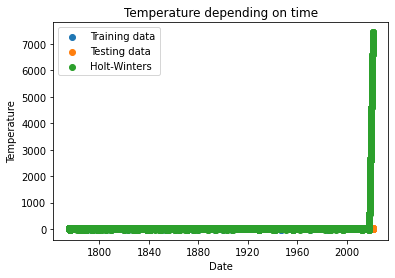

In [18]:
legend_list = [
    "Training data", 
    "Testing data", 
    "Holt-Winters"
]

plt.scatter(training_frame["date"], training_frame["temperature"])
plt.scatter(testing_frame["date"], testing_frame["temperature"])
plt.scatter(date_list_for_smoothed,smoothed_temperature)
plt.legend(legend_list)
plt.title("Temperature depending on time")
plt.xlabel("Date")
plt.ylabel("Temperature");

Vidíme, že predikce dosti znatelně od reality ulétla. Jelikož je úlet monotóní, je zjevné, že problém není v baselině ani v sezónosti, ale v trendu. Zkrátka koeficient beta má nevhodnou velikost. Ono ostatně ani není divu - všechny koeficinety jsme zvolili náhodně. Správně bychom je měli určit nafitování rovnic na trénovací data. Samozřejmě pro různé časové řady takto nabydou parametry různé velikosti.  
Nicméně asi nemá cenu, abychom se optimalizaci parametrů snažili přidat do kódu uvedeného výše a objevovali tak kolo. Holt-Wintersova metoda je totiž i s příslušenstvím již dodána v balíčku **statsmodels** jako **ExponentialSmoothing**. Tento objekt musíme napřed nafitovat (zavolat nad ním metodu **fit**) a predikci následně realizujeme metodou **forecast**. Do ní jako parametr uvedeme, kolik bodů do budoucna vlastně predikovat chceme. Do **ExponentialSmoothing** musíme krom dat na trénování vložit i to, zda trend a sezónost budou aditivní (tj. $trend = y_t - y_{t-1}$) či multiplikativní ($trend = y_t / y_{t-1}$). BACHA - pokud tyto parametry v konstruktoru objektu neuvedeme, bude to Pyothon interpretovat tak, že trend a/nebo sezónost vůbec nechceme.

In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

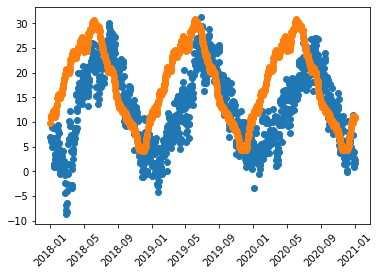

In [20]:
fitted_temperature = ExponentialSmoothing(
    training_frame["temperature"],
    seasonal_periods = 365,
    trend="add",
    seasonal="add",
    damped_trend=True
).fit()


pred_length = len(testing_frame)
prediction_temperature = fitted_temperature.forecast(pred_length)

plt.scatter(testing_frame["date"], testing_frame["temperature"])
plt.scatter(testing_frame["date"], prediction_temperature)
plt.xticks(rotation=45);

Vidíme, že ačkoli je obecně tvar predikce v pořádku, je na časové ose poněkud posunuta. Důvodem je zvolená perioda. 365 dní totiž nereflektuje existenci přestupných roků. Sice se to nezdá, ale v takto dlouhých trénovacích datech může právě tento parametr napáchat solidní paseku. To zřetelně uvidíme, když periodu nastavíme na 366 dní:

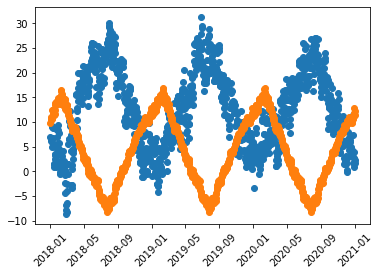

In [21]:
fitted_temperature = ExponentialSmoothing(
    training_frame["temperature"],
    seasonal_periods = 366,
    trend="add",
    seasonal="add",
    damped_trend=True
).fit()


pred_length = len(testing_frame)
prediction_temperature = fitted_temperature.forecast(pred_length)

plt.scatter(testing_frame["date"], testing_frame["temperature"])
plt.scatter(testing_frame["date"], prediction_temperature)
plt.xticks(rotation=45);

Bohužel vstupem dotyčného parametru musí být celé číslo, tudíž se nemůžeme pokoušet o 365,25. Při zkrácení trénovacích dat už je predikce rozumnější, byť je zase poněkud mimo baselina.

c:\vs\programovani\python\casove_rady\environment\lib\site-packages\statsmodels\tsa\base\tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\vs\programovani\python\casove_rady\environment\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
c:\vs\programovani\python\casove_rady\environment\lib\site-packages\statsmodels\tsa\base\tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


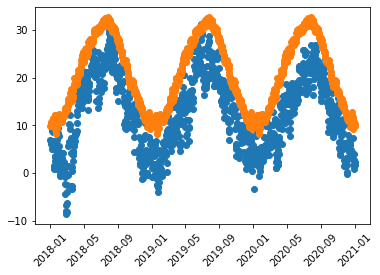

In [22]:
short_start_day = datetime.datetime.strptime("2001-01-01", "%Y-%m-%d")

short_training_frame = klementinum_frame[
    (klementinum_frame["date"]>=short_start_day)
    & (klementinum_frame["date"]<test_start_day)
]

fitted_temperature = ExponentialSmoothing(
    short_training_frame["temperature"],
    seasonal_periods = 365,
    trend="add",
    seasonal="add",
    damped_trend=True
).fit()


pred_length = len(testing_frame)
prediction_temperature = fitted_temperature.forecast(pred_length)

plt.scatter(testing_frame["date"], testing_frame["temperature"])
plt.scatter(testing_frame["date"], prediction_temperature)
plt.xticks(rotation=45);

Pomineme-li tento problém s přestupnými roky, jaké jsou obecnější problémy Holt-Wintersova algoritmu? Jednak ze své podstaty vyžaduje pravidelně navzorkovaná data. Tím mám na mysli, že třeba u časové řady, kdy každý bod znázorńuje jeden den, nesmí občas nějaký den chybět. Takováto mezera by mohla vzniknout jak reálnou absencí měření v onen den, tak tím, že naměřná hodnota byla outlier, který musel být odstraněn. V takových případech nezbývá než mezeru zaplnit prostřednictvím interpolace. Druhý problém Holt-Winterse spočívá v sezónnosti, resp. v počtu sezónností - algoritmus podporuje pouze jednu. V literatuře existuje tzv. Taylor exponential smoothing podporující dvě různé sezónnosti, ten jsem ale v žádném pythoním balíčku nenašel. A pokud by člověk chtěl sezónnosti tři - dejme tomu roční, měsíšní a týdenní - tak už má tuplem smůlu.   

## ARIMA a příbuzné algoritmy

### ACF a PACF
Předtím, než se budeme zabývat ARIMou, bude užitečné seznámit se s autocorrelation function (ACF) a partial autocorrelation function (PACF). Ještě předtím si ale připomeňme, co to vlastně je "klasická" (Pearsonova) korelace. Mějme dvě číselné řady **x** a **y**. Pro korelaci mezi nimi **corr(x,y)** platí vztah  
$corr(x,y) = \frac {kovariance(x,y)}{standardníOdchylka(x) * standardníOdchylka(y)} = \frac {s_{xy}}{s_x s_y}$  
Zde  
$s_{xy} = \frac {1}{n-1} \sum_{k=1}^{n}{(x_k - \overline{x})*(y_k - \overline{y})}$  
$s_x = \sqrt{\frac{1}{n-1}\sum_{k=1}^{n}{(x_k - \overline{x})^2}}$  
Přitom $\overline{x}$ a $\overline{y}$ jsou průměry řad, tj. například  
$\overline{x} = \frac{1}{n}\sum_{k=1}^{n}{x_k}$  
Míra korelace se vždy nachází v intervalu [-1, 1]. Kladnou jedničku bychom dostali, kdybychom korelovali číselnou řadu samu se sebou, mínus jedničku zase když bychom korelovali tu samou řadu s jejím blížencem přenásobeným faktorem -1. Výjimku tvoří konstantní číselná řada. U ní je totiž každý bod roven průměru a tak v členu $s_{xy}$ spolu násobíme dvě nuly.  
Nyní můžeme již přistoupit k ACF. Zde měříme korelaci číselné (v našem kontextu časové) řady se sebou samou - proto ono "auto" v názvu. Jednu z těchto identických časových řad ale posunumeme o k kroků (o k časových jednotek). Mluvíme přitom o lagu o velikosti k. Vyzkoušejme si to na příkladu. Vygenerujme si napřed náhodná šumová data:  

In [2]:
noise_data = np.random.normal(0,100,10)

Vyrobme si nyní dataframe, kde v jednom sloupcu bude původní časové řada a v druhém sloupci řada posunutá o jeden krok dopředu. Velikost dataframu není 10, ale pouze 9 řádků. Výpočet by si totiž neporadil s NaN hodnotou, která posunutím vznikla.

In [3]:
first_acf_frame = pd.DataFrame({
    "orig_data":noise_data[0:9],
    "once_shifted_data":noise_data[1:]  
})
first_acf_frame.corr()

,orig_data,once_shifted_data
orig_data,1.000000,-0.535615
once_shifted_data,-0.535615,1.000000


Proveďme to samé i pro lag o velikosti dva.

In [4]:
second_acf_frame = pd.DataFrame({
    "orig_data":noise_data[0:8],
    "twice_shifted_data":noise_data[2:]  
})
second_acf_frame.corr()

,orig_data,twice_shifted_data
orig_data,1.000000,0.185405
twice_shifted_data,0.185405,1.000000


Kdybychom museli výše uvedený kód opakovat pro každou možnou velikost lagu v určité časové řadě, bylo by to poměrně úmorné. Naštstí existuje funkce **acf** z balíčku **statsmodels**, která to udělá za nás. Jako parametry vložíme řadu k autokorelaci a aby nám čísla spočítaná výše mohla sedět na čísla z **acf** funkce, zadáme i **adjusted**=True.

In [5]:
from statsmodels.tsa.stattools import acf
acf(noise_data, adjusted=True)

array([ 1.        , -0.58349591,  0.19967351,  0.03941171, -0.49329755,
        0.62864932, -0.60836428,  0.31265339, -0.20707987,  0.10438845])

Jenže ta čísla nesedí i tak. Ano, podle očekávání je v poli první bod, odpovídající nulovému lagu, jednička. Pak už dostáváme sice podobné, ale nikoli identické cifry. Čím to je? Inu, zatímco pandí **corr** počítá průměry z řady osekané o přečuhující elementy, **acf** bere v úvahu původní řadu. Podobné je to u normalizace. Že za rozdíl může jenom tato skutečnost se dá nahlédnout použitím následujících funkcí - **autocorr_by_hand** odpovídá pandímu **cor**, **acf_by_hand** zase dělá to samé co **acf**. Zdůrazňuji, že nejsem autor oněch funkcí - ty jsem převzal [odtud](https://stackoverflow.com/questions/36038927/whats-the-difference-between-pandas-acf-and-statsmodel-acf).

In [6]:
def autocorr_by_hand(x, lag):
    # Slice the relevant subseries based on the lag
    y1 = x[:(len(x)-lag)]
    y2 = x[lag:]
    # Subtract the subseries means
    sum_product = np.sum((y1-np.mean(y1))*(y2-np.mean(y2)))
    # Normalize with the subseries stds
    return sum_product / ((len(x) - lag) * np.std(y1) * np.std(y2))

def acf_by_hand(x, lag):
    # Slice the relevant subseries based on the lag
    y1 = x[:(len(x)-lag)]
    y2 = x[lag:]
    # Subtract the mean of the whole series x to calculate Cov
    sum_product = np.sum((y1-np.mean(x))*(y2-np.mean(x)))
    # Normalize with var of whole series
    return sum_product / ((len(x) - lag) * np.var(x))

corr_lag_1 = autocorr_by_hand(noise_data, 1)
corr_lag_2 = autocorr_by_hand(noise_data, 2)
acf_lag_1 = acf_by_hand(noise_data, 1)
acf_lag_2 = acf_by_hand(noise_data, 2)

print(f"Autocorrelation ala pandas by hand for lag 1: {corr_lag_1}, for lag 2: {corr_lag_2}.")
print(f"Autocorrelation ala statsmodels by hand for lag 1: {acf_lag_1}, for lag 2: {acf_lag_2}.")

Autocorrelation ala pandas by hand for lag 1: -0.5356152533576097, for lag 2: 0.18540506779885269.
Autocorrelation ala statsmodels by hand for lag 1: -0.5834959092598351, for lag 2: 0.19967351392316823.


ACF pro různé lagy najednou můžeme vizualizovat prostřednictvím ACF grafu. Ten nemusíme nijak složitě programovat, stačí nám zavolat funkci **plot_acf**. Poznamenejme, že funkce **plot_acf** graf jednak vrací, jednak zobrazuje. Abychom ho tak v Jupyteru neviděli dvakrát, potlačíme zobrazení vráceného objektu pomocí středníku.

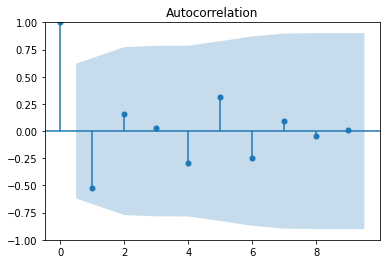

In [9]:
plot_acf(noise_data);

Co v ACF grafu znázorňuje světle modrá plocha? Jedná se o oblast nesignifikance - veškeré body, které se v ní nacházejí, jsou totiž tak malé, že nemají žádnou statistickou výpovědní hodnotu. V našem konkrétním případě nám graf říká, že naše časová řada se sebou už při lagu jedna nekoreluje. To ale odpovídá našemu očekávání - řadu jsme vytvořili jako posloupnost náhodných čísel, jako šum.  

Vysvětlení partial autocorrelation function (PACF) bude o něco komplikovanější. Zde se pokusím o zkrácenou verzi, verze delší (ze které pochází i následující regresní kód) se nachází [na tomto odkazu](https://timeseriesreasoning.com/contents/partial-auto-correlation/). Mějme původní časovou řadu a řadu posunutou o dvě časové jednotky. Může se stát, že spolu tyto dvě řady korelují "napřímo" (protože se třeba něco děje každé dvě časové jednotky). Také to ale může znamenat, že původní řada korelovala s řadou posunutou o jednu jednotku a potom řada posunutá o jednu jednotku korelovala s řadou posunutou o jednotky dvě. PACF v sobě zachycuje první zmíněný případ. Fakticky se jedná o korelaci mezi 
- mírou variance časové řady s nulovým posunem, která se nedá vysvětlit variancí časové řady s posunem jedna
- a mírou variance časové řady s posunem dva, která se nedá vysvětlit varianci časové řady s posumen jedna 

Variance je kovariance řady se sebou samou, tj.  
$var(x) = kovariance(x,x) = \frac{1}{n} \sum_{k=1}^{n}{(x_k - \overline{x})^2} $  


Kdyby nám šlo o obecnější případ a posun by byl **n**, v odrážkách by byly variance všech časových řad s posunem od 1 do **n-1**.   

Tohle je všechno pěkné, ale jak PACF vypočíst? Nejprve si ukážeme "ruční" výpočet. Opět si nagenerujeme šumová data, tentokráte ale o něco delší než minule. Důvod spočívá v tom, že následně se budeme snažit nafitovat lineární regresí data v různě posunutých časových řadách na sebe. K takové operaci je lepší mít bodů více (čti při 10 bodech mi výsledek tohoto postupu nesouhlasi s výsledkem **pacf** funkce ze **statsmodels**). Následně si spočítáme rezidua jednak mezi řadami s lagem 0 a 1, jednak mezi řadami s lagem 2 a 1. Nakonec vypočteme korelaci mezi těmito rezidui.

In [20]:
from sklearn import linear_model

manual_pacf_comp_frame = pd.DataFrame({
    "shift_0": np.random.normal(0,100,1000)
})
manual_pacf_comp_frame["shift_1"] = manual_pacf_comp_frame["shift_0"].shift(1)
manual_pacf_comp_frame["shift_2"] = manual_pacf_comp_frame["shift_0"].shift(2)
manual_pacf_comp_frame = manual_pacf_comp_frame.dropna()

lim_model_0_1 = linear_model.LinearRegression()
predictors_0_1 = manual_pacf_comp_frame[["shift_1"]]
target_0_1 = manual_pacf_comp_frame["shift_0"]
lim_model_0_1.fit(predictors_0_1,target_0_1)
manual_pacf_comp_frame["predicted_shift_0"] = lim_model_0_1.predict(predictors_0_1)
manual_pacf_comp_frame["residuals_0_1"] = manual_pacf_comp_frame["shift_0"] - manual_pacf_comp_frame["predicted_shift_0"]

lim_model_2_1 = linear_model.LinearRegression()
predictors_2_1 = manual_pacf_comp_frame[["shift_1"]]
target_2_1 = manual_pacf_comp_frame["shift_2"]
lim_model_2_1.fit(predictors_2_1,target_2_1)
manual_pacf_comp_frame["predicted_shift_2"] = lim_model_2_1.predict(predictors_2_1)
manual_pacf_comp_frame["residuals_2_1"] = manual_pacf_comp_frame["shift_2"] - manual_pacf_comp_frame["predicted_shift_2"]

manual_pacf_comp_frame[["residuals_0_1", "residuals_2_1"]].corr()

,residuals_0_1,residuals_2_1
residuals_0_1,1.00000,-0.03925
residuals_2_1,-0.03925,1.00000


Stejně jako u ACF i u PACF existuje funkce, která vypočte PACF pro hromadu lagů naráz. Nás kvůli porovnánívýsledku této funkce s přístupem výše zajímá třetí číslo ve vypsaném poli. 

In [21]:
from statsmodels.tsa.stattools import pacf
pacf(manual_pacf_comp_frame["shift_0"])

array([ 1.        ,  0.0498459 , -0.0396498 ,  0.02061498, -0.02353353,
        0.0494872 , -0.01406118,  0.03561908, -0.00480988, -0.04454898,
       -0.0278956 ,  0.02071022,  0.06598133, -0.01983056, -0.01251745,
       -0.03724296,  0.02219044,  0.02490316,  0.03050494,  0.00331068,
        0.03085487, -0.04283666, -0.04232144,  0.01427604, -0.01088947,
        0.03237071,  0.0305656 , -0.01949164, -0.00190314, -0.03141192])

Existuje i funkce PACF vizualizující. Světle modré pozadí má stejný význam jako u ACF grafu.

c:\vs\programovani\python\casove_rady\environment\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


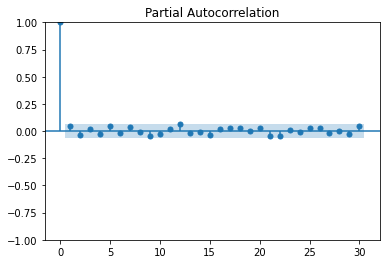

In [22]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(manual_pacf_comp_frame["shift_0"]);

### ARIMA
Po přeci jen trochu delší odbočce můžeme přejít k algoritmu skrývajícímu se pod názvem ARIMA. Tato zkratka vznikla ze slov AutoRegressive Integrated Moving Average. Už tento název napovídá, že se ARIMA skládá ze tří složek. Máme tu autoregresní část, ve které se predikce veličiny **y** v čase **t** získává lineární regresí využívající hodnoty té samé veličiny (proto předpona auto) v minulosti. Přetaveno do vzorečku:  
$y_t = \alpha + \beta_1 y_{t-1} + \beta_2 y_{t-2} + ... +  \beta_p y_{t-p} + \epsilon_t $  
Zde $\alpha$ představuje konstantní člen (intercept), bety značí váhy redukující vliv minulých hodnot veličiny **y** a  $\epsilon_t$ zastupuje chybu predikce. Všimněme si parametru **p** - ten říká, kolik předešlých hodnot dané veličiny k predikci využijeme.  
Slovíčko "Integrated", kterým se ARIMA liší od příbuzné metody ARMA, umožňuje ARIMě pracovat s částí nestacionárních řad, konkrétně s řadami, ve kterých je pozorovatelný nějaký trend. Jak autoregrese, tak moving average totiž moc nefungují, pakliže jsou prediktory - v našem případě hodnoty určité veličiny v různém čase - vzájemně dlouhodobě korelované. No a právě "I" část ARIMY dělá z nestacionární časové řady řadu stacionární, čímž je korelace odstraněna.    
Vzoreček pro moving average vypadá následovně:  
$y_t = \mu + \epsilon_t + \phi_1 \epsilon_{t-1} + \phi_2 \epsilon_{t-2} + ... + \phi_q \epsilon_{t-q} $   
Zde $\mu$ je očekávaná hodnota řady (tj. průměr),  $\epsilon_t$ má stejný význam jako u autoregrese - chybu predikce v čase **t**. Lze předpokládat, že výslednou predikci ovlivní i velikosti chyby v předcházejících časových bodech - idea je zhruba taková, že se člověk snaží reagovat na minulé omyly. Jelikož ale tyto omyly patří bližší či vzdálenější minulosti, musí být přenásobeny váhami $\phi$. Stejně jako autoregrese měla parametr **p**, má moving average parametr **q** říkající, kolik minulých chyb použijeme.  
Když tedy autoregresi i moving average dáme dohromady, dostaneme vzorec  
$y_t = konst + \beta_1 y_{t-1} + \beta_2 y_{t-2} + ... +  \beta_p y_{t-p} + \epsilon_t + \phi_1 \epsilon_{t-1} + \phi_2 \epsilon_{t-2} + ... + \phi_q \epsilon_{t-q}$  
Samozřejmě při fitování se vypustí $\epsilon_t$, protože ten v daný okamžik neznáme. Fitováním určíme váhy $\beta$ a $\phi$, avšak paramtry **p**, **q** a **d** (ten je spjat s "integrated" částí ARIMY) musíme nalézt jinak.

ARIMA je použitelná pouze pro nesezónní časové řady- sezónnost totiž podobně jako trend přináší nestacionaritu. Jelikož tedy není možné použít data týkající se teplot, musíme si vyrobit umělou časovou řadu.

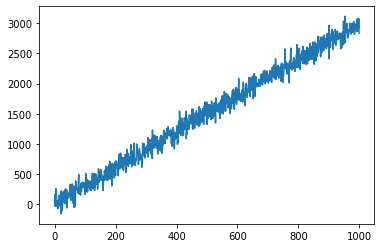

In [2]:
fake_series_x = list(range(0,1000))
fake_series_noise = np.random.normal(0,100,1000)
fake_series_y = []
for index, elem in enumerate(fake_series_x):
    fake_series_y.append(3*elem + fake_series_noise[index])

plt.plot(fake_series_y);

Parametr **d** určíme jako nejmenší řád derivace, který je třeba na stacionarizaci řady. Na zjištění toho, že je řada již stacionární, použijeme ACF graf, tedy funkci **plot_acf**. Pokud bychom do ní chtěli vložit sloupec dataframu (pandas.Series) či numpoidní pole, šlo by to bez jakéhokoli problému. Obyčejný list ale musí být napřed převedený právě na numpoidní pole, tj. musí se psát **plot_acf(np.array(noise_data))**.    

Zobrazme si ACF graf napřed pro nijak nezpracovaná data.

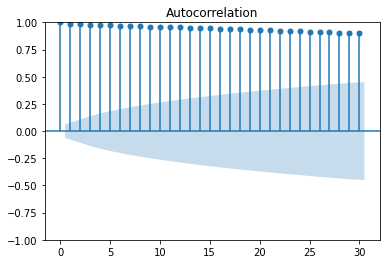

In [3]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(np.array(fake_series_y));

Není překvapující, že pro nulový posun je korelace jednotková. Velká je ale i pro velký počet nenulových posunů. To znamená, že je časovou řadu třeba stacionarizovat. Jak to ale provedeme? Inu, napřed si musíme uvědomit, co vlastně chceme provést. Představme si například, že bychom měli šum nasázený na rostoucí funkci y = 2x. Pak bychom takovýto růst odstranili odečtením n-tého členu od n+1 členu. Když si uvědomíme, že tyto členy jsou od sebe vzdáleny o jednu jednotku, tak takovým odečítáním fakticky realizujeme derivaci. 

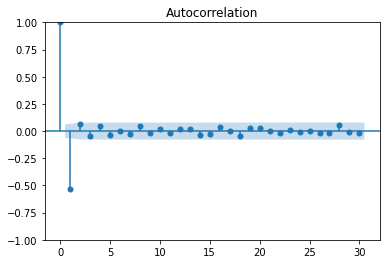

In [4]:
plot_acf(np.diff(np.array(fake_series_y)));

Vidíme, že po provedení derivace korelace velmi rychle padá navíc s tím, že změnila znaménko. Takovouto řadu už za stacionární prohlásit můžeme. Obecně pokud je korelace kladná pro 10+ posunů, je třeba derivování provést. Obvykle ale stačí první, maximálně druhé derivace. Pokud to člověk přežene a korelace je příliš záporná, je řada už přederivovaná.  
Pokud se pro rozhodování o (ne)derivování nechceme rozhodovat okometricky, ale na základě čísla, můžeme použít tzv. Augmented Dickey-Fuller test. Zde se z praktického úhlu pohledu jedná o otestování hypotézy, že je řada nestacionární. Tj. pokud bude p-hodnota menší než 0.05, nulová hypotéza se musí zavrhnout a o řadě tak řekneme, že stacionární je. 

In [5]:
from statsmodels.tsa.stattools import adfuller
p_value_no_diff = adfuller(fake_series_y)[1]
p_value_first_diff = adfuller(np.diff(np.array(fake_series_y)))[1]
print(f"p-value of time series without derivation: {p_value_no_diff}; with derivation: {p_value_first_diff}.")

p-value of time series without derivation: 0.932730836216874; with derivation: 1.5924196288009062e-23.


ACF graf po stacionarizaci lze využít i na zjistění parametru **q**. Ten se určí jako počet signifikatních hodnot autokorelace následujících po sobě s tím, že se vynechává bod odpovídající nulovému lagu. Tomu v našem případě odpovídá pouze jeden bod, tudíž **q** = 1. 

Parametr **p** určíme pomocí PACF grafu obdobným způsobem jako počet bodů od počátku (s vynecháním lagu 0), které se nalézají nad čárou signifikance.

c:\vs\programovani\python\casove_rady\environment\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


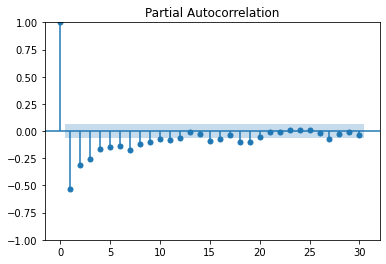

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(np.diff(np.array(fake_series_y)));

Určení tohoto počtu je v tomto konkrétním případě poněkud komplikované - velké množstív bodů se nachází těsně nad okrajem signifikance. Zkusíme položit **p=9**.  

Nyní konečně vytvoříme ARIMA model pomocí stejnojmenného konstruktoru. Parametry **p**, **d**, **q** se do něj v tomto pořadí vkládají v podobě tuplu předávaného jako parametr **order**.

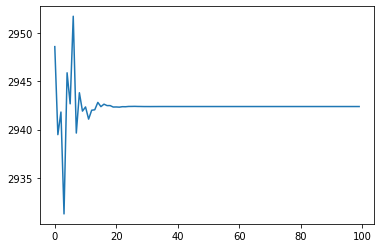

In [7]:
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(fake_series_y, order=(9,1,1))
model_fit = arima_model.fit()
arima_forecast = model_fit.forecast(100)
plt.plot(arima_forecast);

Takovouto predikci jsme nečekali - trénovací data byla přeci očividně rostoucí. Důvodem je to, že metoda **forecast** defaultně ukazuje predikci bez trendu. Pokud máme lineární trend, musíme ho do výsledku dotlačit přidáním parametru **trend** s hodnotou "t" do konstrukturu ARIMy.

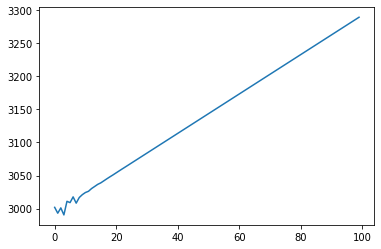

In [8]:
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(fake_series_y, order=(9,1,1), trend="t")
model_fit = arima_model.fit()
arima_forecast = model_fit.forecast(100)
plt.plot(arima_forecast);

Pro model si lze zobrazit i shrnující report a to sice pomocí provolání metody **summary** na nafitovaném modelu. V tomto reportu se pod zkratkou AIC skrývá Akaine information criterion. Tato veličina nám dává informaci o kvalitě modelu. Dá se říci, že když srovnáváme dva modely, lepší je ten s menším AIC. AIC v sobě zahrnuje jak přesnost fitu, tak jednoduchost modelu, tj. zahrnuje v sobě jak overfitting, tak underfitting. Vzoreček pro něj je  
$AIC = 2k - 2 \ln{\hat{L}}$   
Zde **k** značí počet parametrů modelu a $\hat{L}$ zase maximální hodnotu likehood funkce modelu (aka podmínečnou pravděpodobnost získání změřených dat při zadaných parametrech modelu).  
BIC značí Bayesian information criterion. Principielně je podobné AIC (vč. toho, že menší hodnota je lepší), penalizace za počet parametrů je ale u BIC vetší než u AIC. Předpis pro BIC vypadá následovně (**n** je počet počet pozorování):  
$BIC = \ln{n} k - 2 \ln{\hat{L}}$   
HQIC je Hannan-Quinn information criterion.  
$HQIC = 2k \ln{\ln{n}}- 2 \hat{L}$   
Zajímavá je také tabulka s řádky typu ar.Lčíslo a maLčíslo. Zde vidíme koeficienty spajté s AR či MA. Zajímavý je zejmána sloupec P>|z| - pokud je hodnota zde větší než 0.05, nedá se odmítnout hypotéza, že koeficient by měl mít nulovou hodnotu, tj. fakticky by v modelu být neměl.

In [9]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(9, 1, 1)   Log Likelihood               -6012.557
Date:                Fri, 04 Feb 2022   AIC                          12049.113
Time:                        20:00:21   BIC                          12107.994
Sample:                             0   HQIC                         12071.493
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.9809      0.017    170.849      0.000       2.947       3.015
ar.L1         -0.0153      0.031     -0.492      0.623      -0.076       0.046
ar.L2          0.0559      0.033      1.703      0.089      -0.008       0.120
ar.L3          0.0031      0.032      0.097      0.923      -0.060       0.067
ar.L4          0.0260      0.034      0.776      0.438      -0.040       0.092
ar.L5         -0.0309      0.032     -0.955      0.340      -0.094       0.033
ar.L6         -0.0299      0.032     -0.947      0.344      -0.092       0.032
ar.L7         -0.0114      0.032     -0.360      0.719      -0.074       0.051
ar.L8          0.0543      0.032      1.692      0.091      -0.009       0.117
ar.L9          0.0190      0.033      0.577      0.564      -0.046       0.084
ma.L1         -1.0000      0.713     -1.402      0.161      -2.397       0.398
sigma2      9823.2622   7022.877      1.399      0.162   -3941.323    2.36e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.40
Prob(Q):                              0.98   Prob(JB):                         0.82
Heteroskedasticity (H):               0.99   Skew:                            -0.01
Prob(H) (two-sided):                  0.94   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Pakliže nechceme parametry ARIMy určovat ručně, můžeme tuto úlohu nechat na automatu z balíčku **pmdarima**. Všimněme si, že zde jsme žádný parametr **trend** zadávat nemuseli. Výsledek se nezdá okometricky ale úplně nejlepší (predikce se v bodě 100 nedostane ani na hodnotu 3 200) a z reportu vidíme, že AIC tu je mírně horší než při ručním ladění parametrů. Možná se ptáte, co vlastně v reportu znamená slovo SARIMAX. To si povíme v následujících podkapitolách.

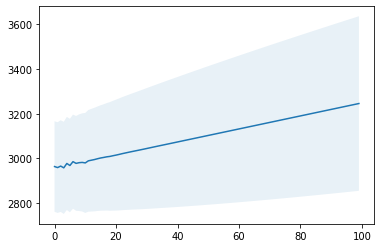

In [10]:
import pmdarima as pm

model_auto = pm.auto_arima(fake_series_y, seasonal=False, start_p=0, start_q=0, max_p=10, max_q=10)
forecast_auto, conf_interval = model_auto.predict(n_periods=100, return_conf_int=True)

conf_int_lower = [elem[0] for elem in conf_interval]
conf_int_upper = [elem[1] for elem in conf_interval]

plt.plot(forecast_auto)
plt.fill_between(list(range(100)), conf_int_lower, conf_int_upper, alpha=0.1)

In [26]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:              SARIMAX(10, 1, 0)   Log Likelihood               -6068.493
Date:                Thu, 03 Feb 2022   AIC                          12160.985
Time:                        21:10:44   BIC                          12219.866
Sample:                             0   HQIC                         12183.365
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     15.9111      3.547      4.486      0.000       8.959      22.863
ar.L1         -0.8919      0.033    -27.004      0.000      -0.957      -0.827
ar.L2         -0.7689      0.045    -17.220      0.000      -0.856      -0.681
ar.L3         -0.6671      0.051    -13.121      0.000      -0.767      -0.567
ar.L4         -0.5421      0.052    -10.486      0.000      -0.643      -0.441
ar.L5         -0.4035      0.054     -7.523      0.000      -0.509      -0.298
ar.L6         -0.3326      0.053     -6.308      0.000      -0.436      -0.229
ar.L7         -0.2880      0.052     -5.488      0.000      -0.391      -0.185
ar.L8         -0.2428      0.049     -4.909      0.000      -0.340      -0.146
ar.L9         -0.1534      0.043     -3.562      0.000      -0.238      -0.069
ar.L10        -0.1034      0.030     -3.404      0.001      -0.163      -0.044
sigma2      1.107e+04    506.619     21.850      0.000    1.01e+04    1.21e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.69
Prob(Q):                              0.91   Prob(JB):                         0.71
Heteroskedasticity (H):               0.85   Skew:                            -0.06
Prob(H) (two-sided):                  0.15   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### SARIMA
SARIMA je ARIMA, která bere v úvahu i sezónní komponenty. Z hlediska parametrů to znamená, že k původní trojici **p**, **d**, **q** přibude **P**, **D**, **Q** a **m**. Parametr **m** odpovídá periodě sezónnosti. **P**, **D** a **Q** mají stejný význam jako **p**, **d** a **q**, jen se týkají sezónní části dat.   

Původní idea byla taková, že práci se SARIMou demonstrujeme na teplotních datech z Klementina. Bohužel nejenže můj počítač nezvládne zpracovat při periodě 365 dní původní trénovací data, extrémní problém má i při trénovacích datech omezených na pouhých deset let. Proto jsme nuceni si i zde vyrobit data umělá. 

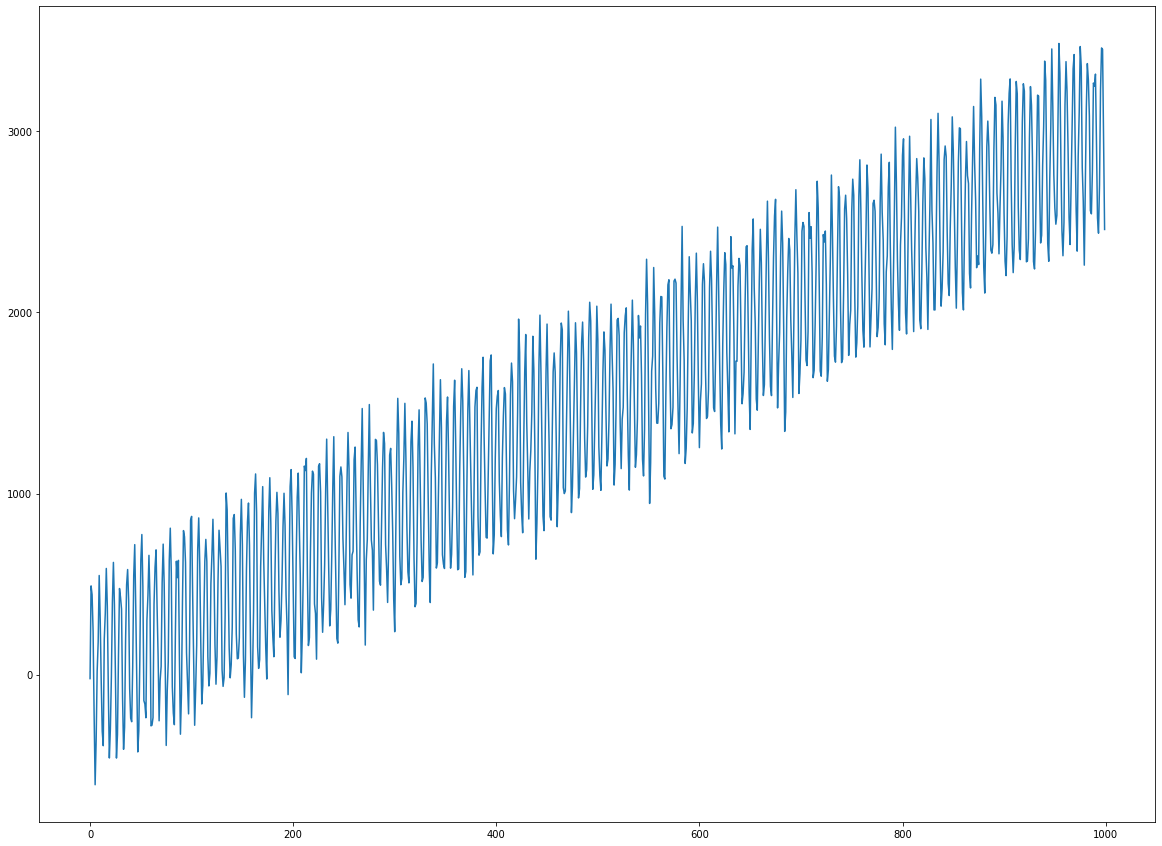

In [16]:
fake_series_x = list(range(0,1000))
fake_series_noise = np.random.normal(0,100,1000)
fake_series_y = []
amplitude = 500
period = 7
for index, elem in enumerate(fake_series_x):
    fake_series_y.append(3*elem + amplitude*math.sin(2*3.14*elem/period) + fake_series_noise[index])

plt.figure(figsize=(20,15))
plt.plot(fake_series_y);

fake_periodic_train = fake_series_y[0:801]
fake_periodic_test = fake_series_y[801:]

V ACF grafu vidíme jednak periodickou složku, jednak složku konstantní. Konstantní složka je velká pro nakritický počet bodů, tudíž derivace (ve smyslu **d** = 1) bude nutná.

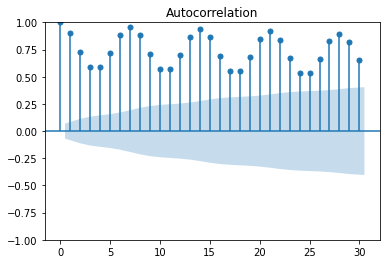

In [4]:
plot_acf(np.array(fake_periodic_train));

Po derivace je v ACF grafu viditelná už jenom periodická složka. O smyslu její derivace by se dalo pochybovat - přeci jen jsme ji výše definovali jako sinus, který se derivací pouze fázově posune.

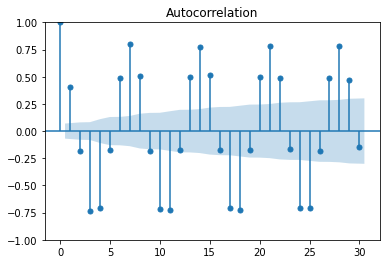

In [6]:
plot_acf(np.diff(np.array(fake_periodic_train)));

c:\vs\programovani\python\casove_rady\environment\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


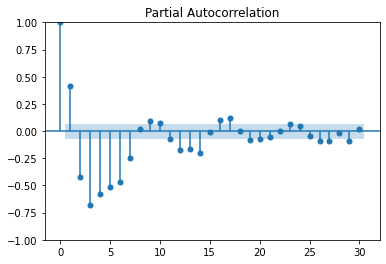

In [7]:
plot_pacf(np.diff(np.array(fake_periodic_train)));

Nyní vyvstává otázka, jak v takovýchto datech určit koeficienty **q**, **Q**, **p** a **P**. Přeci jenom vzhledem ke krátké periodě se tyto příspěvky v datech projeví současně. Asi nejjednodušší by bylo použít grid search z pmdarimy, nicméně zkusme napřed parametry určit ručně.  
V obrázcích výše se moc dobře sezónní a nesezónní příspěvky odlišit nedají. Člověka by napadlo, že je to dáno funkcí sinus v sezónnosti, ale podobné problémy byly i při použití jiných typů periodicity.   
Nejprve zkusme z dat vytáhnout čistou sezónní složku. Z ACF grafu (a tedy také z toho, jak jsme původní data vygenerovali) vidíme, že perioda sezónnosti činí 7 časových jednotek. Vezměme tedy každý sedmý bod ze zderivovaných dat. Abychom omezili vliv nesezónních vlivů, proveďme tuto operaci pro první až sedmý bod sezónnosti. Následně sedm takto získaných posloupností zprůměrujme. Zde je nutné zajistit, aby všechny řady měly stejnou délku - proto je řada explicitně useknutá na 798 obdech, i když v trénovacích datech bylo bodů 800.

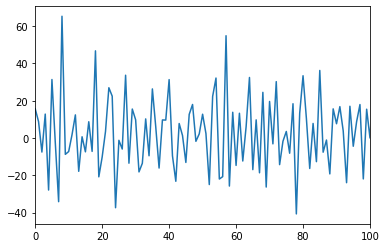

In [46]:
differentiated_time_series = np.diff(np.array(fake_periodic_train))

average_diff_series = (
    differentiated_time_series[:798:7]
    + differentiated_time_series[1:798:7]
    + differentiated_time_series[2:798:7]
    + differentiated_time_series[3:798:7]
    + differentiated_time_series[4:798:7]
    + differentiated_time_series[5:798:7]
    + differentiated_time_series[6:798:7]
)
average_diff_series = [elem/7 for elem in average_diff_series]

plt.plot(average_diff_series)
plt.xlim((0,100));

Na základě grafů se tak zdá, že **P** = 1 a **Q** = 3.

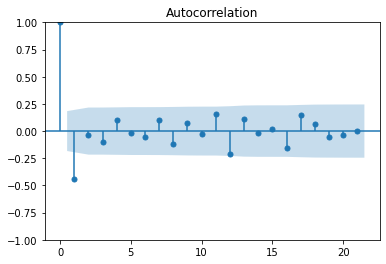

In [47]:
plot_acf(np.array(average_diff_series));

c:\vs\programovani\python\casove_rady\environment\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


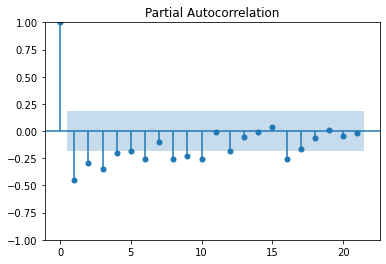

In [48]:
plot_pacf(np.array(average_diff_series));

Co se nesezónní složky týče, zkusme napřed napočíst hodnoty pro jednu průměrnou periodu, tu potom x-krát zduplikovat a odečíst ji od původních zderivovaných dat.

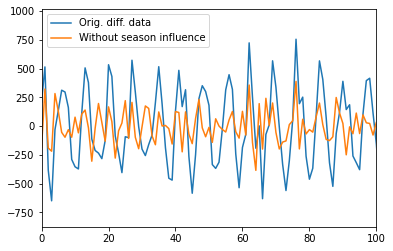

In [67]:
differentiated_time_series

periods_count = len(differentiated_time_series)//7
point_1 = sum(differentiated_time_series[:798:7])/periods_count
point_2 = sum(differentiated_time_series[1:798:7])/periods_count
point_3 = sum(differentiated_time_series[2:798:7])/periods_count
point_4 = sum(differentiated_time_series[3:798:7])/periods_count
point_5 = sum(differentiated_time_series[4:798:7])/periods_count
point_6 = sum(differentiated_time_series[5:798:7])/periods_count
point_7 = sum(differentiated_time_series[6:798:7])/periods_count
average_period = [point_1, point_2, point_3, point_4, point_5, point_6, point_7]

diff_without_periodicity = differentiated_time_series[:798] - average_period*periods_count

plt.plot(differentiated_time_series)
plt.plot(diff_without_periodicity)
plt.legend(["Orig. diff. data", "Without season influence"])
plt.xlim((0,100));

Zdá se, že poté **p** = 7 a **q** = 1.

c:\vs\programovani\python\casove_rady\environment\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


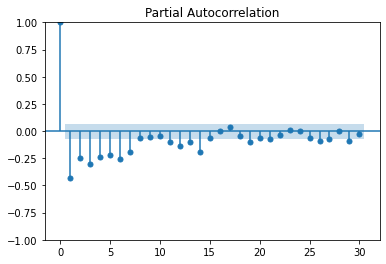

In [63]:
plot_pacf(np.array(diff_without_periodicity));

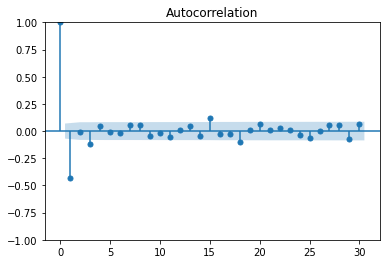

In [64]:
plot_acf(np.array(diff_without_periodicity));

Pro SARIMu neexistuje separání funkce/objekt. Fakticky je zaintegrovaná do ARIMy, u které je parametr **seasonal_order**, do kterého se v pořadí **P**, **D**, **Q**, **m** vkádají sezónní parametry. Když bychom se pokusili vložit do konstruktoru **order**=(7,1,1) a **seasonal_order**=(1, 0, 3, 7), dostali bychom chybovou hlášku
```
ValueError: Invalid model: autoregressive lag(s) {7} are in both the seasonal and non-seasonal autoregressive components.
```
To je kvůli tomu, že implementace ARIMy se chce v autoregresi vyhnout opakovanému využití stejného bodu. Parametr **p** =7 totiž říká, že pro určení jednoho konkrétního bodu jsou třeba lagy 1, 2, 3, 4, 5, 6, 7. No a parametr **P**=1 zase vynucuje, že se pro určení toho samého bodu použije lag 7. Abychom tento problém odstranili, změníme **p** na hodnotu 6.  
Nyní proběhlo už fitování úspěšně. Když predikci porovnáme s očekávanými hodnotami, uvidíme, že výsledke je vcelku uspokojivý. 

c:\vs\programovani\python\casove_rady\environment\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\vs\programovani\python\casove_rady\environment\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


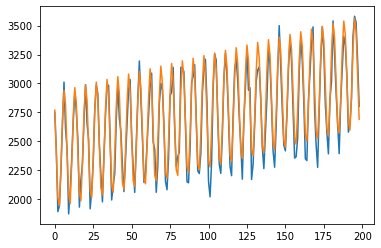

In [71]:
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(fake_periodic_train, order=(6,1,1), seasonal_order=(1, 0, 3, 7), trend="t")
forecast_length = len(fake_periodic_test)
model_fit = arima_model.fit()
model_forecast = model_fit.forecast(forecast_length)

plt.plot(fake_periodic_test)
plt.plot(model_forecast);

In [72]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  801
Model:             ARIMA(6, 1, 1)x(1, 0, [1, 2, 3], 7)   Log Likelihood               -4910.706
Date:                                 Sat, 05 Feb 2022   AIC                           9847.412
Time:                                         15:09:32   BIC                           9908.312
Sample:                                              0   HQIC                          9870.807
                                                 - 801                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.5062      0.324     10.809      0.000       2.870       4.142
ar.L1         -0.9327      0.032    -28.956      0.000      -0.996      -0.870
ar.L2         -0.9290      0.032    -28.896      0.000      -0.992      -0.866
ar.L3         -0.9610      0.022    -43.631      0.000      -1.004      -0.918
ar.L4         -0.9661      0.019    -51.151      0.000      -1.003      -0.929
ar.L5         -0.9366      0.029    -31.965      0.000      -0.994      -0.879
ar.L6         -0.9210      0.039    -23.903      0.000      -0.997      -0.846
ma.L1         -0.0044      0.057     -0.078      0.937      -0.115       0.106
ar.S.L7        0.8681      0.117      7.439      0.000       0.639       1.097
ma.S.L7       -1.6815      0.113    -14.845      0.000      -1.904      -1.460
ma.S.L14       0.6381      0.137      4.664      0.000       0.370       0.906
ma.S.L21       0.0789      0.052      1.527      0.127      -0.022       0.180
sigma2      1.577e+04   1032.513     15.276      0.000    1.37e+04    1.78e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.50   Jarque-Bera (JB):                 1.27
Prob(Q):                              0.48   Prob(JB):                         0.53
Heteroskedasticity (H):               0.94   Skew:                            -0.03
Prob(H) (two-sided):                  0.63   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Zkusme na sezónní data vypustit pmdarimu. Zde do provolání přidáme 'error_action="ignore"', neboť jinak by se při trénování objevila hromada warningů.

In [75]:
model_auto = pm.auto_arima(fake_periodic_train, m=7,start_q=0, start_p=0, n_jobs=-1, seasonal=True, error_action="ignore")
forecast_length = len(fake_periodic_test)
forecast_auto, conf_interval = model_auto.predict(n_periods=forecast_length, return_conf_int=True)

c:\vs\programovani\python\casove_rady\environment\lib\site-packages\pmdarima\arima\_validation.py:77: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


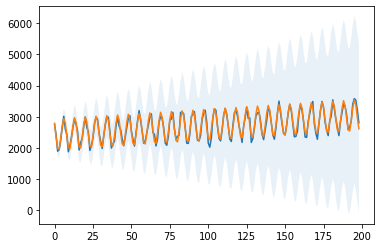

In [76]:
conf_int_lower = [elem[0] for elem in conf_interval]
conf_int_upper = [elem[1] for elem in conf_interval]

plt.plot(fake_periodic_test)
plt.plot(forecast_auto)
plt.fill_between(list(range(forecast_length)), conf_int_lower, conf_int_upper, alpha=0.1)

In [77]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  801
Model:             SARIMAX(3, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -4994.720
Date:                             Sat, 05 Feb 2022   AIC                          10003.439
Time:                                     15:17:52   BIC                          10036.232
Sample:                                          0   HQIC                         10016.037
                                             - 801                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.026      0.005      0.996      -0.050       0.050
ar.L1         -0.7187      0.035    -20.413      0.000      -0.788      -0.650
ar.L2         -0.5041      0.038    -13.209      0.000      -0.579      -0.429
ar.L3         -0.3259      0.033     -9.739      0.000      -0.391      -0.260
ar.S.L7        1.0000   1.39e-05   7.17e+04      0.000       1.000       1.000
ma.S.L7       -0.9289      0.013    -72.442      0.000      -0.954      -0.904
sigma2      1.473e+04   3.03e-07   4.86e+10      0.000    1.47e+04    1.47e+04
===================================================================================
Ljung-Box (L1) (Q):                   3.71   Jarque-Bera (JB):                 2.41
Prob(Q):                              0.05   Prob(JB):                         0.30
Heteroskedasticity (H):               0.89   Skew:                             0.04
Prob(H) (two-sided):                  0.32   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+26. Standard errors may be unstable.
"""

### (S)ARIMAX

Nyní se dostáváme k záhadnému slovu SARIMAX, které jsme zaregistrovali v summary zprávách pmdarimy. Jde o SARIMu (resp. ARIMu, pokud je sezónní složka nepřítomná), která navíc bere v úvahu exogenní příspěvky. Exogenním příspěvkem myslíme něco, co do modelu vstupuje z vnějšku, co se model nenaučil ze vstupních dat. Příkladem relevantním pro časové řady může být seznam svátků, který můžeme použít, když v trénovacích datech nění dostatečně velká historie. V kontrastu k tomu stojí endogenní příspěvek alias to, co si model sám vyčte z trénovacích dat.  
Pro demonstraci si vyrobme opět monotónně rostoucí zašuměná data. Novinkou je ale nyní skutečnost, že do určitých bodů umístíme spike, tj. k jistým náhodně vybraným bodům přidáme podstatný příspěvek.

In [36]:
fake_series_noise = np.random.normal(0,20,500)
exo_flag_column = []
fake_series_y = []
spike_magnitude = 150
spikes_index = [10, 47, 85, 150, 224, 284, 350, 380, 415, 456, 489]
for timepoint_index in range(0,500):
    if timepoint_index in spikes_index:
        exo_flag_column.append(1)
        fake_series_y.append(3*timepoint_index + spike_magnitude + fake_series_noise[timepoint_index])
    else:
        exo_flag_column.append(0)
        fake_series_y.append(3*timepoint_index + fake_series_noise[timepoint_index])     

fake_train = fake_series_y[0:401]
fake_exo_train = exo_flag_column[0:401]
fake_test = fake_series_y[401:]
fake_exo_test = exo_flag_column[401:]

S ACF a PACF grafy budeme operovat jako v předchpzích případech. 

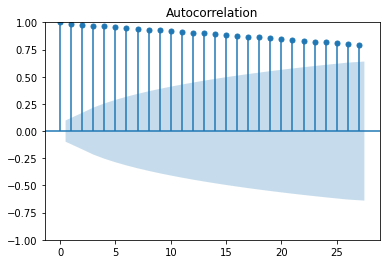

In [37]:
plot_acf(np.array(fake_train));

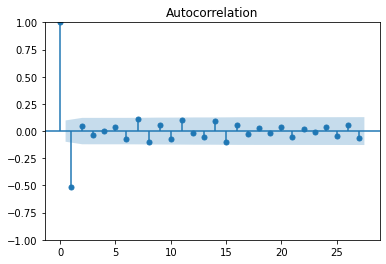

In [38]:
plot_acf(np.diff(np.array(fake_train)));

c:\vs\programovani\python\casove_rady\environment\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


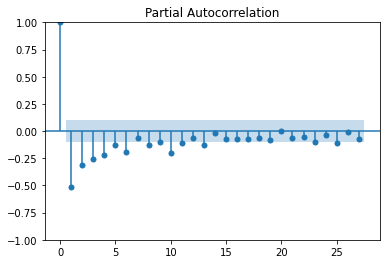

In [39]:
plot_pacf(np.diff(np.array(fake_train)));

Do konstruktoru ARIMA přidáme parametr **exog** s příznaky toho, u kterých bodů v trénovací množině byl přidán spike. ARIMA si pak spojí tento příznak s odpovídacím vzrůstem hodnoty na y-ové ose, což se posléze aplikuje v metodě **forecast** při výrobě předpovědi. I ve **forecast** se nachází parametr **exog**, do kterého vkládáme příznaky spiku pro testovací množinu. V grafu sorvnávajícím původní data s předpovědí vidíme, že ARIMA na námi určená místa spiku nasadila hodnoty ve správné velikosti.

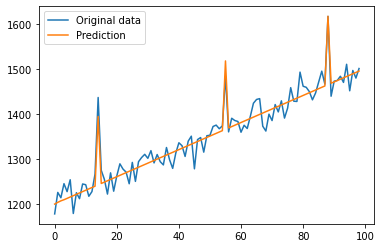

In [41]:
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(fake_train, order=(3,1,1), trend="t", exog=fake_exo_train)
forecast_length = len(fake_test)
model_fit = arima_model.fit()
model_forecast = model_fit.forecast(forecast_length, exog=fake_exo_test)

plt.plot(fake_test)
plt.plot(model_forecast);
plt.legend(["Original data", "Prediction"])

In [35]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  401
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -1798.452
Date:                Sat, 05 Feb 2022   AIC                           3610.904
Time:                        20:32:43   BIC                           3638.844
Sample:                             0   HQIC                          3621.968
                                - 401                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.9922      0.008    355.359      0.000       2.976       3.009
x2           151.0696     11.738     12.870      0.000     128.064     174.075
ar.L1         -0.0574      0.051     -1.134      0.257      -0.157       0.042
ar.L2         -0.0123      0.051     -0.239      0.811      -0.113       0.088
ar.L3         -0.0942      0.051     -1.860      0.063      -0.194       0.005
ma.L1         -0.9997      0.239     -4.176      0.000      -1.469      -0.530
sigma2       463.5210    114.652      4.043      0.000     238.808     688.234
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.08
Prob(Q):                              0.97   Prob(JB):                         0.58
Heteroskedasticity (H):               1.17   Skew:                            -0.05
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Facebook Prophet   
Práce s algoritmy diskutovanými v předchozích kapitolách bývá pro složitost a kryptičnost jejich nastavování občas poněkud komplikovaná. Oproti tomu autoři balíčku [Facebook Prophet](https://facebook.github.io/prophet/docs/quick_start.html) se snažili v tomto ohledu práci uživateli usnadnit - parametry metod mají obvykle jasný význam. Prophet se od předchozích postupů liší i svou podstatou - nespoléhá na "klasickou" časovou závislost, tj. pro bod v čase **t** nezkoumá body v čase **t**-1, **t**-2 atd. K fitování časových řad přistupuje jako k fitování obyčejného (nečasového) grafu. To v praxi znamená, že fitování bývá rychlejší a že nevadí, když je v časové řadě nějaký ten záznam vynechán. Další praktickou výhodou Prophetu je skutečnost, že podporuje použití několika sezónností najednou.   
Samozřejmě i zde existují určité problémy. Asi nejpodstatnějším z nich je otázka instalace - z pipu se mi balíček [Prophet](https://facebook.github.io/prophet/docs/installation.html) zatím nikdy nainstalovat nepodařilo. Problém je skryt v jedné z prerekvizit - v balíčku **pystan**, který asi vyžaduje nějaké hodně specifické nastavení Cčkového kompilátoru. Veselý je navíc i fakt, že se instalace pystanu tváří úspěšně, přestože se fakticky nepovede. Jak vypadá řešení této situace? Člověk musí použít Anacondí distribuci a Prophet poté stáhnout z [condího repozitáře](https://anaconda.org/conda-forge/prophet).   

Při fitování se Prophet časovou řadu snaží proložit rovnicí  
$y(t) = g(t) + s(t) + h(t) + \epsilon_t$  
Zde **g(t)** zastupuje trend alis neperiodické změny řady, **s(t)** reprezentuje sezónnosti alias periodické změny a **h(t)** představuje spikeový vliv svátků. Nakonec $\epsilon_t$ značí šum. Podrobněji si podobu jednotlivých elementů probereme, až budeme zkoumat jejich provázanost s parametry konstruktoru a metod. Předtím si ale představíme out-of-the-box zacházení s Prophetem bez jakýchkoli složitých nastavení.   

Prophet jako vstup vyžaduje pandí dataframe se dvěma sloupci. První se musí jmenovat **ds** a musíme obsahovat buďto datum ve formátu YYYY-MM-DD, anebo timestampu ve formátu YYYY-MM-DD HH:MM:SS. Druhý sloupec se musí jmenovat **y** - v něm budou hodnoty veličiny, kterou chceme predikovat.

In [9]:
training_frame_prophet = training_frame[["date", "temperature"]].copy()
training_frame_prophet.columns = ["ds", "y"] 
training_frame_prophet.head()

,ds,y
0,1775-01-01,-7.0
1,1775-01-02,-2.2
2,1775-01-03,-1.0
3,1775-01-04,0.1
4,1775-01-05,2.2


Vytvoříme instanci Prophet modelu a provedeme fitování.

In [10]:
from prophet import Prophet
prophet_model = Prophet()
prophet_model.fit(training_frame_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Pro predikci napřed musíme vytvořit dataframe obsahující sloupec s datumy odpovídajícími jak trénovacím datům, tak oblasti predikce. Toho dosáhneme provoláním metody **make_future_dataframe**, které do parametru **periods** předáme počet bodů, které chceme predikovat.

In [11]:
full_dates_frame = prophet_model.make_future_dataframe(periods=len(testing_frame))

In [12]:
full_dates_frame.tail()

,ds
89845,2020-12-27
89846,2020-12-28
89847,2020-12-29
89848,2020-12-30
89849,2020-12-31


Samotné predikování pak realizujeme s pomocí metody **predict**, která jako vstup dostane právě dataframe s datumy.

In [13]:
forecast = prophet_model.predict(full_dates_frame)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()

,ds,yhat,yhat_lower,yhat_upper
0,1775-01-01,-1.124545,-5.806869,3.260470
1,1775-01-02,-1.118558,-6.273430,3.571835
2,1775-01-03,-1.219530,-6.004682,3.671615
3,1775-01-04,-1.254078,-5.954599,3.748517
4,1775-01-05,-1.280403,-5.798084,3.527989


Vidíme, že predikce sedí na reálná data. Zdůrazněme, že jsme zde nemuseli nijak štelovat nastavení modelu, takto funguje Prophet v základním nastavení.

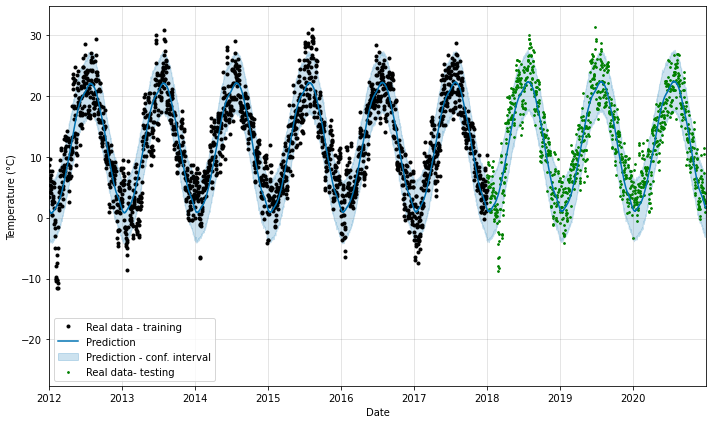

In [14]:
x_axis_left_limit_str = "2012-01-01"
x_axis_right_limit_str = "2020-12-31"
x_axis_left_limit = datetime.datetime.strptime(x_axis_left_limit_str, "%Y-%m-%d")
x_axis_right_limit = datetime.datetime.strptime(x_axis_right_limit_str, "%Y-%m-%d")

prophet_model.plot(forecast)
plt.xlim((x_axis_left_limit, x_axis_right_limit))
plt.scatter(
    x=testing_frame["date"], 
    y=testing_frame["temperature"],
    s=3,
    c="green"
)
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend([
    "Real data - training", 
    "Prediction",
    "Prediction - conf. interval",
    "Real data- testing"
]);

Krom predikce samotné si člověk může vizualizovat trend a jednotlivé sezónní složky.

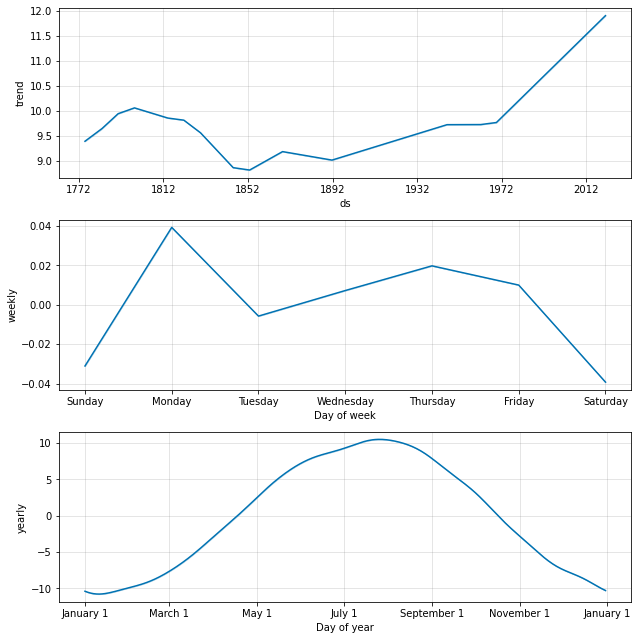

In [15]:
prophet_model.plot_components(forecast);

### Trend a saturace růstu
Defaultně Prophet používá pro fitování trendu lineární model. Nicméně to nemusí bý vždy nejvhodnější volba - trend může být saturován na tzv. "carrying capacity". Jedná se například o maximální množství lidí, kteří si mohou pořídit určitý výrobek. Nutno podotknout, že carrying capacity se může v čaase měnit, například počet potenciálních zákazníků může s lety růst. Trend **g(t)** zachycující takovýto děj se poté dá popsat rovnicí  
$g(t) = \frac{C(t)}{1+exp(-k(t-m))}$  
Zde **C(t)** představuje carrying capacity, **k** míru růstu a **m** časový offset.  
Jak se saturovaným růstem pracovat? Ukažme si to na poněkud nerealisticých datech, kdy je přechod mezi růstem a saturací okamžitý. Do trénovacích dat musíme přidat sloupec **cap**. Hodnoty v něm - carrying capacity - mohou být jak (v rámci sloupce) kosntantní, nebo mohou být pro každý řádek různé. 

In [16]:
saturating_growth_frame = pd.DataFrame({
    "ds": pd.date_range("2022-01-01", "2022-06-30", freq="D"),
    "y": [number for number in range(150)] + 31*[150]
})
sat_growth_frame_train = saturating_growth_frame[:130].copy()
sat_growth_frame_train["cap"] = 150
sat_growth_frame_test = saturating_growth_frame[130:]

Konstruktor **Prophet** musíme provolat s parametrem **growth** majícím hodnotu "logistic" (defaultní je "linear"). Do dataframu s daty musíme ještě před provoláním metody **predict** přidat také sloupec **cap**. Ve finálním obrázku posléze vidíme jednak čáru znázorňující saturaci, jednak predikci o tvaru právě saturací ovlivněném.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


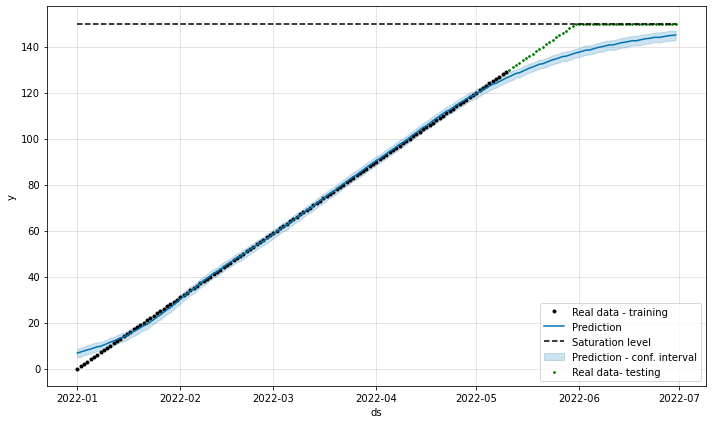

In [17]:
prophet_model = Prophet(growth = "logistic")
prophet_model.fit(sat_growth_frame_train)

full_dates_frame = prophet_model.make_future_dataframe(periods=len(sat_growth_frame_test))
full_dates_frame["cap"] = 150
forecast = prophet_model.predict(full_dates_frame)

prophet_model.plot(forecast)
plt.scatter(
    x=sat_growth_frame_test["ds"], 
    y=sat_growth_frame_test["y"],
    s=3,
    c="green"
)
plt.legend([
    "Real data - training", 
    "Prediction",
    "Saturation level",
    "Prediction - conf. interval",
    "Real data- testing"
]);

Saturováno nemusí být pouze maximum, ale i minimum. V takovém případě nepoužijeme sloupec **cap**, ale sloupec **floor**.

### Changepointy v trendu
Dá se předpokládat, že se v trendu časové řady na dostatečně dlouhé časové ose objeví prudké změny související se změnou podmínek majících vliv na sledovanou veličinu. Kdyby nebyla tato skutečnost brána v úvahu, predikci by to mohlo negativně ovlivnit. Proto si Prophet v datech vybere určitý počet potenciálních changepointů (defaultně je jich 25) a snaží se zjistit, zda se v nich trend skutečně mění.  
Changepointy (faktické, nikoli potenciální) si lze vizualizovat pomocí **add_changepoints_to_plot**.

In [18]:
saturating_growth_frame = pd.DataFrame({
    "ds": pd.date_range("2022-01-01", "2022-06-30", freq="D"),
    "y": (
        [0.5*number for number in range(30)] 
        + [0.5*29+1.5*number for number in range(40)] 
        + [0.5*29+1.5*39-0.5*number for number in range(50)] 
        + [0.5*29+1.5*39-0.5*49+0.5*number for number in range(61)]
    )
})
sat_growth_frame_train = saturating_growth_frame[:130]
sat_growth_frame_test = saturating_growth_frame[130:]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


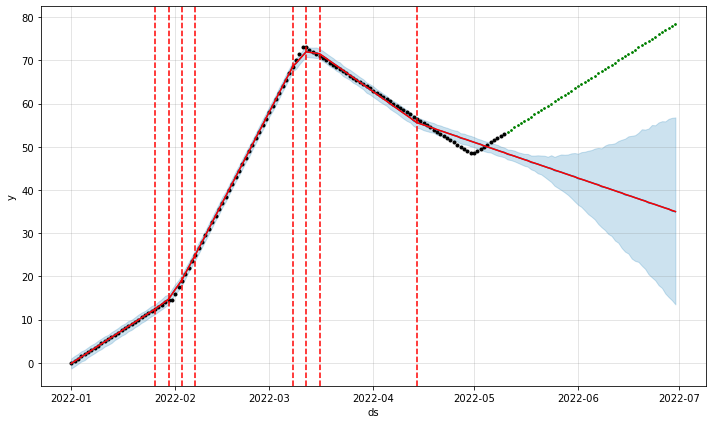

In [19]:
from prophet.plot import add_changepoints_to_plot

prophet_model = Prophet()
prophet_model.fit(sat_growth_frame_train)

full_dates_frame = prophet_model.make_future_dataframe(periods=len(sat_growth_frame_test))
forecast = prophet_model.predict(full_dates_frame)

fig = prophet_model.plot(forecast)
add_changepoints_to_plot(fig.gca(), prophet_model, forecast)
plt.scatter(
    x=sat_growth_frame_test["ds"], 
    y=sat_growth_frame_test["y"],
    s=3,
    c="green"
)

Defautlně Prophet changepointy hledá v prvních 80% trénovacích dat - dál nejde kvůli nebezpečí overfittingu. Nicméně toto proceto je možné modifikovat pomocí parametru **changepoint_range** v konstruktoru. Vidíme, že pokud použijeme hodnotu 0.99 (aka 99%), je registrována i poslední změna v našich trénovacích datech.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


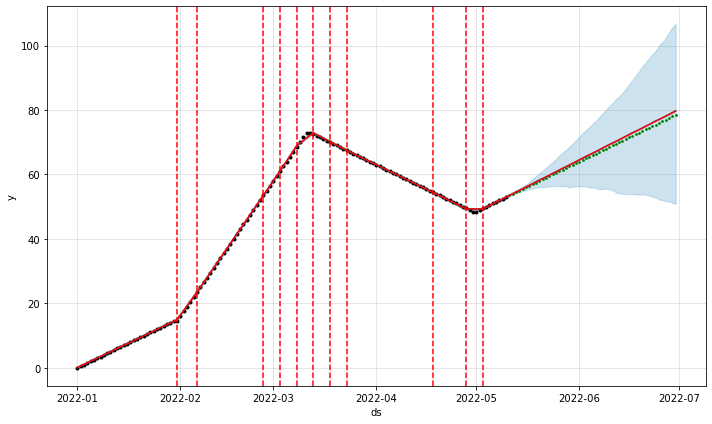

In [20]:
prophet_model = Prophet(changepoint_range=0.99)
prophet_model.fit(sat_growth_frame_train)

full_dates_frame = prophet_model.make_future_dataframe(periods=len(sat_growth_frame_test))
forecast = prophet_model.predict(full_dates_frame)

fig = prophet_model.plot(forecast)
add_changepoints_to_plot(fig.gca(), prophet_model, forecast)
plt.scatter(
    x=sat_growth_frame_test["ds"], 
    y=sat_growth_frame_test["y"],
    s=3,
    c="green"
)

Changepointy mohou být definovány i manuálně a to s pomocí parametru **changepoints**, který se umístí do konstruktoru. Zdůrazněme, že takto definované changepointy se k changepointům původním nepřidávají, nýbrž je nahrazují.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


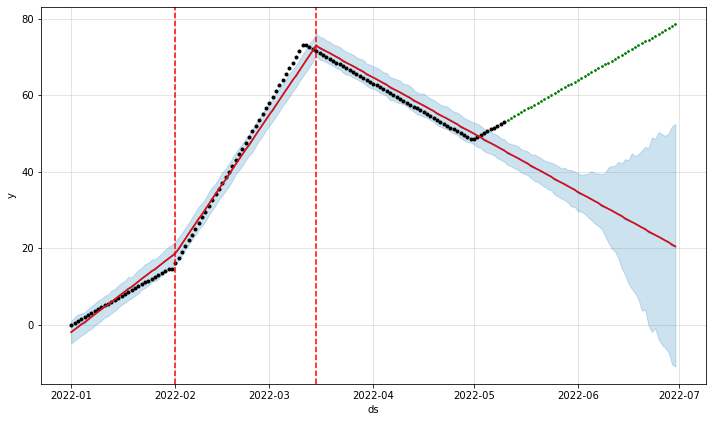

In [21]:
prophet_model = Prophet(changepoints=["2022-02-01", "2022-03-15"])
prophet_model.fit(sat_growth_frame_train)

full_dates_frame = prophet_model.make_future_dataframe(periods=len(sat_growth_frame_test))
forecast = prophet_model.predict(full_dates_frame)

fig = prophet_model.plot(forecast)
add_changepoints_to_plot(fig.gca(), prophet_model, forecast)
plt.scatter(
    x=sat_growth_frame_test["ds"], 
    y=sat_growth_frame_test["y"],
    s=3,
    c="green"
)

### Sezónnost
Příspěvek od jednoho typu sezónnosti **s(t)** má podobu  
$s(t) = \sum_{n=1}^{N}(a_n cos(\frac{2\pi nt}{P_r}) + b_n cos(\frac{2\pi nt}{P_t}))$  
Zde **P** perioda o velikosti 365,25 dnů resp. 7 dnů pro roční resp. týdenní sezónnost. Parametry **a** a **b** se snažíme určit fitováním.  
Defaultně Prophet používá týdenní a roční sezónnost. Pakliže pro ně ale v datech nenajde odůvodnění, neaplikuje je. Toto chování můžeme vynutit, pakliže do konstruktoru **Prophet** do parametrů **yearly_seasonality** resp. **weekly_seasonality** dáme namísto defaultní "auto" buďto True, nebo False.  
Co máme ale dělat v případě, že bychom chtěli použít sezónnost vlastní, například měsíční? K modelu ji připojíme pomocí metody **add_seasonality**. Jaké parametry v ní použijeme? Parametr **name** specifikuje jméno sezónnosti, které se posléze objeví například při zavolání **plot_components**. Parametr **period** říká, jaká je vlastně perioda sezónnosti - pro měsíc použijeme hodnotu 30.5 (ano, zde nám to kazí únor). Nakonec je tu parametr **fourier_order**, který představuje **N** z rovnice o pár řádků výše. Stanovení jeho velikosti není úplně přímočaré, nicméně pro představu - defaultní týdenní sezónnost má N=3, pro defaultní roční sezónnost N=10.

In [22]:
month_season_frame = pd.DataFrame({
    "ds": pd.date_range("2022-01-01", "2022-06-30", freq="D"),
    "y": (
        [10*math.sin(2*3.14*number/30) for number in range(181)] 

    )
})
month_season_frame_train = month_season_frame[:130]
month_season_frame_test = month_season_frame[130:]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


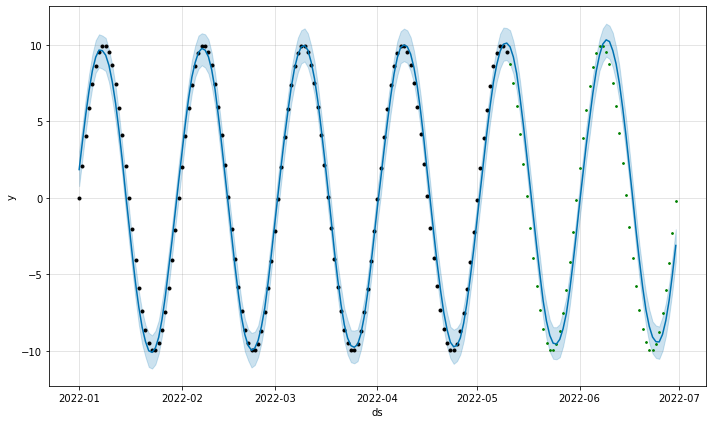

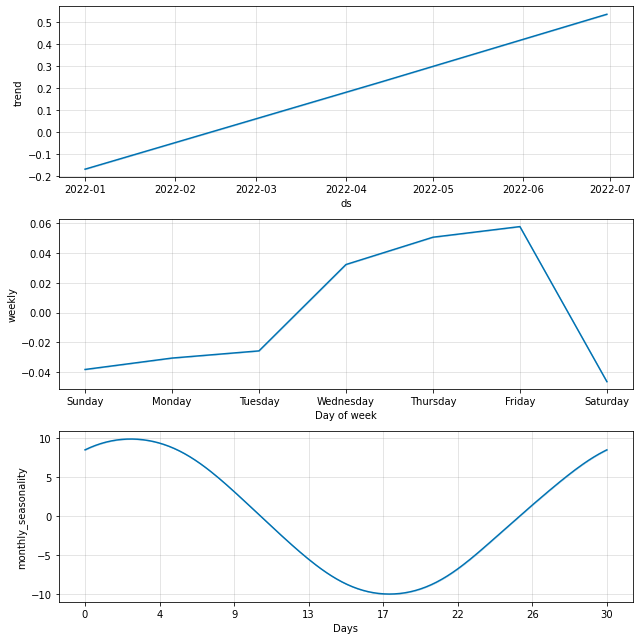

In [24]:
prophet_model = Prophet()
prophet_model.add_seasonality(name="monthly_seasonality", period=30.5, fourier_order=5)
prophet_model.fit(month_season_frame_train)

full_dates_frame = prophet_model.make_future_dataframe(periods=len(month_season_frame_test))
forecast = prophet_model.predict(full_dates_frame)

prophet_model.plot(forecast)
plt.scatter(
    x=month_season_frame_test["ds"], 
    y=month_season_frame_test["y"],
    s=3,
    c="green"
)

prophet_model.plot_components(forecast);

### Svátky  
Občas se v záznamech v určitých dnech, které dopředu známe, objeví atypičnost - chování projevující se spikem ve zkoumané veličině. Asi nejobvyklejším příkladem takovéhoto chování jsou svátky.  
Pro demonstraci postupu, jak se Prophet s touto situací dokáže vypořádat, si napřed vytvořme monotónně rostoucí data, na které posléze nasázíme spiky. Všimněte si, že zatímco spiky "A" mají den poté určitý dozvuk, u spiků "B" se objevuje velký signál den předem. To dává smysl, neboť třeba takové Vánoce se mohou kupříkladu v nákupu potravin projevit 23.12. 

In [25]:
year_frame = pd.DataFrame({
    "ds": pd.date_range("2022-01-01", "2022-12-31", freq="D"),
    "y": [0.5*number for number in range(365)]
})
labels_increase_a = [34, 62, 86, 177, 202, 208, 250, 266, 293, 326]
for one_label in labels_increase_a:
    year_frame["y"].loc[one_label] = 500 + year_frame.loc[one_label]["y"]
    year_frame["y"].loc[one_label+1] = 200 + year_frame.loc[one_label+1]["y"]

labels_increase_b = [2, 69, 90, 120, 180, 335]
for one_label in labels_increase_b:
    year_frame["y"].loc[one_label] = 400 + year_frame.loc[one_label]["y"]
    year_frame["y"].loc[one_label-1] = 400 + year_frame.loc[one_label-1]["y"]

year_frame_train = year_frame[:301]
year_frame_test = year_frame[301:]

c:\users\newnotebook\miniconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Pro potřeby Prophetu si napřed musíme vyrobit dataframe, ve kterém budou svátky zapsané. Onen dataframe musí mít dva sloupce - "holiday", do něhož napíšeme jméno svátku, a "ds", ve kterém bude list datumů svátku. Je možné přidat sloupce "lower_window" a "upper_window" zachycující, kolik dnů před či po svém "základním" datu navíc svátek ovlivní. Zdůrazněme, že pokud chceme použít "lower_window", musíme do něj vložit záporné číslo.

In [26]:
holiday_a = pd.DataFrame({
  "holiday": "holiday_A",
  "ds": pd.to_datetime([
      "2022-02-04", "2022-03-04", "2022-03-28", 
      "2022-06-27", "2022-07-22", "2022-07-28",
      "2022-09-08", "2022-09-24", "2022-10-21",
      "2022-11-23"
  ]),
  "lower_window": 0,
  "upper_window": 1,
})
holiday_b = pd.DataFrame({
  "holiday": "holiday_B",
  "ds": pd.to_datetime([
      "2022-01-03", "2022-03-11", "2022-04-01",
      "2022-05-01", "2022-06-30", "2022-12-02"
  ]),
  "lower_window": -1,
  "upper_window": 0,
})
holidays = pd.concat((holiday_a, holiday_b))

Se samotným konstruktorem **Prophet** se pracuje jak v předchozích příkladech, pouze se do něj umístí parametr **holidays**, do kterého se vloží dataframe s údaji o svátcích. Algoritmus se pak na trénovacích záznamech naučí, s jakou změnou je ten který svátek svázán, a tyto změny pak promítne do výpočtu předpovědi.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


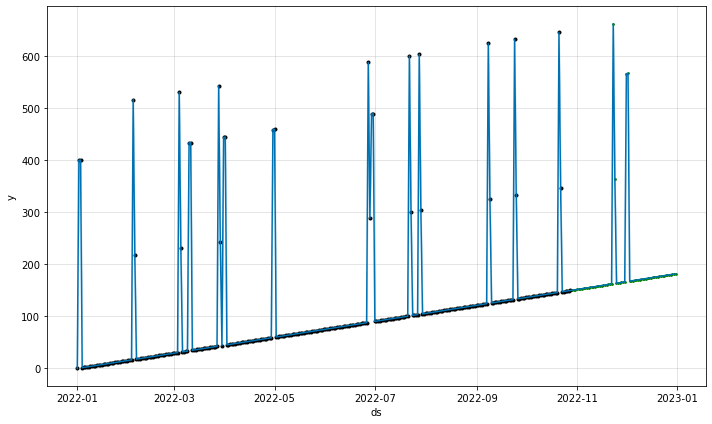

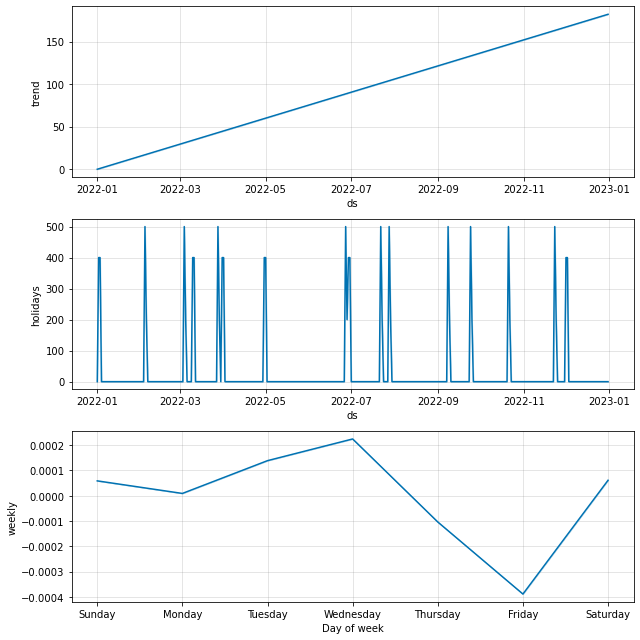

In [27]:
prophet_model = Prophet(holidays=holidays)
prophet_model.fit(year_frame_train)

full_dates_frame = prophet_model.make_future_dataframe(periods=len(year_frame_test))
forecast = prophet_model.predict(full_dates_frame)

prophet_model.plot(forecast)
plt.scatter(
    x=year_frame_test["ds"], 
    y=year_frame_test["y"],
    s=3,
    c="green"
)

prophet_model.plot_components(forecast);